Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7626072157987265
            Iterations: 23
            Function evaluations: 189
            Gradient evaluations: 23

Final Results:
W = 2.00, D = -11.0, <sz1> = 0.46089, <sz2> = 0.63546, Norm = 0.76261
Optimal alpha: 0.011590, 0.191506, -0.078227, -0.225007, 0.026972, 0.270922


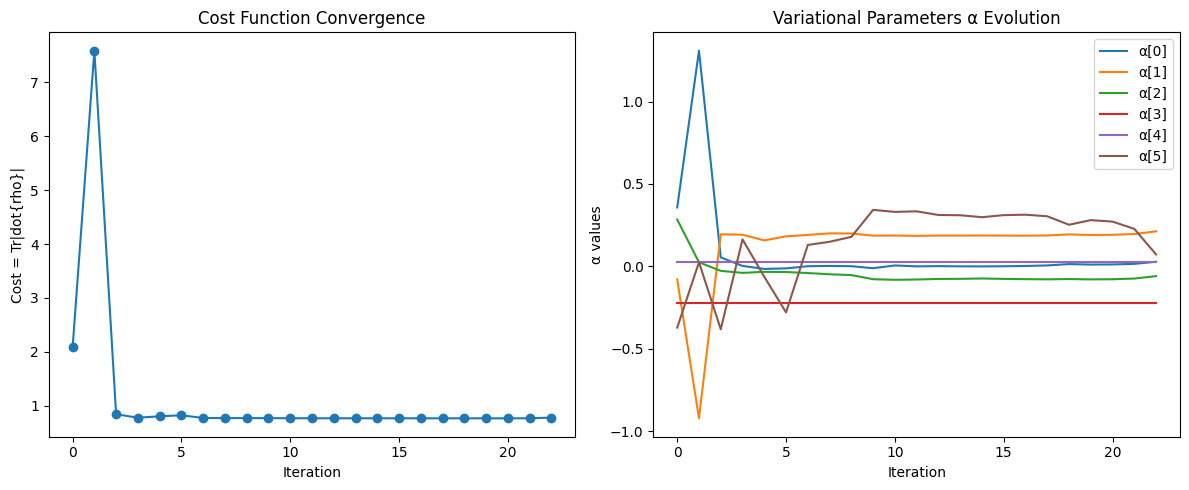

In [7]:

from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout

# Pauli operators and identity
sm = destroy(2)
sp = sm.dag()
Pr = sp * sm
Pg = qeye(2) - Pr

sz = Pr - Pg
sx = sm + sp
sy = 1j * (sm - sp)
s0 = qeye(2)

sigma = [s0, sx, sy, sz]

# Parameters
W = 4.0
d = 2
V = 10. / d
D = -11.

# Lists to track optimization progress
cost_history = []
alpha_history = []

# Commutator definition
def commutator(x, y):
    return x * y - y * x

# Variational cost function: Tr|𝜌̇|
def fun(alpha):
    rho_1 = (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.
    rho_2 = (qeye(2) + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2.
    rho_12 = tensor(rho_1, rho_1)

    Hl = W / 2. * (tensor(sx, s0) + tensor(s0, sx))
    Hint = V / 4. * tensor(sz, sz)
    Heff = V / 4. * ((rho_2 * sz).tr() * tensor(sz, s0) +
                     (rho_1 * sz).tr() * tensor(s0, sz))

    L = [tensor(sm, s0), tensor(s0, sm)]
    H = Hl + Hint + Heff
    vne_1 = -1j * commutator(H, rho_12)

    for c in L:
        vne_1 += c * rho_12 * c.dag() - 0.5 * (c.dag() * c * rho_12 + rho_12 * c.dag() * c)

    return sum(abs(vne_1.eigenenergies()))

# Callback function to track progress
def callback(alpha):
    val = fun(alpha)
    cost_history.append(val)
    alpha_history.append(alpha.copy())

# Plotting routine
def plot_results():
    plt.figure(figsize=(12, 5))

    # Cost function convergence
    plt.subplot(1, 2, 1)
    plt.plot(cost_history, '-o')
    plt.title("Cost Function Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Cost = Tr|dot{rho}|")

    # Variational parameters
    plt.subplot(1, 2, 2)
    alpha_arr = np.array(alpha_history)
    for i in range(alpha_arr.shape[1]):
        plt.plot(alpha_arr[:, i], label=f"α[{i}]")
    plt.title("Variational Parameters α Evolution")
    plt.xlabel("Iteration")
    plt.ylabel("α values")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main logic (traditional top-level script style)
# -----------------------------------------------
alpha = [-0.02601224115, 0.177396605947, -0.0193666716675,
         -0.225007108541, 0.0269723275427, -0.515769761814]

W = 3.9

for W in [2.0]:
    result = minimize(
        fun, alpha, method='SLSQP',
        options={'ftol': 1e-6, 'disp': True},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.},
        callback=callback
    )

    if not result.success:
        print('# Optimization failed for W =', W)
        break

    print("\nFinal Results:")
    print(
        "W = {:.2f}, D = {:.1f}, <sz1> = {:.5f}, <sz2> = {:.5f}, Norm = {:.5f}".format(
            W, D, (1. + result.x[2]) / 2., (1. + result.x[5]) / 2., fun(result.x)
        )
    )
    print("Optimal alpha:", ", ".join(f"{v:.6f}" for v in result.x))
    stdout.flush()

plot_results()


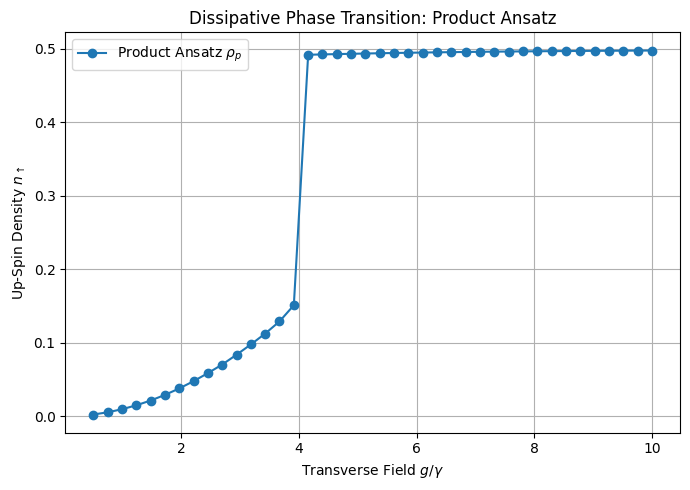

In [18]:
from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Operators
sm, sp = destroy(2), destroy(2).dag()
Pr = sp * sm
Pg = qeye(2) - Pr

sz = Pr - Pg
sx = sm + sp
sy = 1j * (sm - sp)
s0 = qeye(2)
sigma = [sx, sy, sz]

# Parameters
V = 5.0      # Interaction strength
gamma = 1.0  # Decay rate
W_vals = np.linspace(0.5, 10.0, 40)  # Transverse field sweep

# Storage
n_up_prod, cost_prod = [], []

# --- Helper functions ---
def commutator(x, y):
    return x * y - y * x

# PRODUCT STATE ANSATZ 
def cost_product(alpha, W):
    rho_1 = (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.
    rho_2 = (qeye(2) + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2.
    rho_12 = tensor(rho_1, rho_2)

    Hl = W / 2. * (tensor(sx, s0) + tensor(s0, sx))
    Hint = V / 4. * tensor(sz, sz)
    Heff = V / 4. * ((rho_2 * sz).tr() * tensor(sz, s0) +
                     (rho_1 * sz).tr() * tensor(s0, sz))
    H = Hl + Hint + Heff
    L = [tensor(sm, s0), tensor(s0, sm)]

    drho = -1j * commutator(H, rho_12)
    for c in L:
        drho += c * rho_12 * c.dag() - 0.5 * (c.dag()*c*rho_12 + rho_12*c.dag()*c)

    return sum(abs(drho.eigenenergies()))

# Optimization loop
alpha0 = [-0.1, 0.05, 0.1, -0.1, 0.05, -0.1]

for W in W_vals:
    res_p = minimize(
        cost_product, alpha0, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_p.success:
        alpha_opt = res_p.x
        sz1 = (1. + alpha_opt[2]) / 2.
        sz2 = (1. + alpha_opt[5]) / 2.
        n_avg_p = (sz1 + sz2) / 2
        n_up_prod.append(n_avg_p)
        cost_prod.append(cost_product(alpha_opt, W))
        alpha0 = alpha_opt
    else:
        n_up_prod.append(np.nan)
        cost_prod.append(np.nan)

# --- Final Plot ---
plt.figure(figsize=(7, 5))
plt.plot(W_vals, n_up_prod, 'o-', label='Product Ansatz $\\rho_p$')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Up-Spin Density $n_\\uparrow$")
plt.title("Dissipative Phase Transition: Product Ansatz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


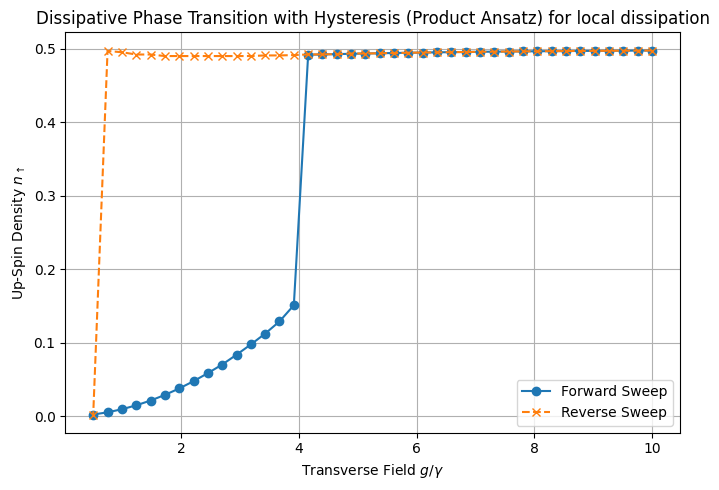

In [26]:
from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Operators
sm, sp = destroy(2), destroy(2).dag()
Pr = sp * sm
Pg = qeye(2) - Pr

sz = Pr - Pg
sx = sm + sp
sy = 1j * (sm - sp)
s0 = qeye(2)
sigma = [sx, sy, sz]

# Parameters
V = 5.0      # Interaction strength
gamma = 1.0  # Decay rate
W_vals = np.linspace(0.5, 10.0, 40)  # Transverse field sweep

# Storage
n_up_prod, cost_prod = [], []
n_up_prod_reverse = []

# --- Helper functions ---
def commutator(x, y):
    return x * y - y * x

# PRODUCT STATE ANSATZ 
def cost_product(alpha, W):
    rho_1 = (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.
    rho_2 = (qeye(2) + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2.
    rho_12 = tensor(rho_1, rho_2)

    Hl = W / 2. * (tensor(sx, s0) + tensor(s0, sx))
    Hint = V / 4. * tensor(sz, sz)
    Heff = V / 4. * ((rho_2 * sz).tr() * tensor(sz, s0) +
                     (rho_1 * sz).tr() * tensor(s0, sz))
    H = Hl + Hint + Heff
    L = [tensor(sm, s0), tensor(s0, sm)]

    drho = -1j * commutator(H, rho_12)
    for c in L:
        drho += c * rho_12 * c.dag() - 0.5 * (c.dag()*c*rho_12 + rho_12*c.dag()*c)

    return sum(abs(drho.eigenenergies()))

# Forward Sweep
alpha0 = [-0.1, 0.05, 0.1, -0.1, 0.05, -0.1]
for W in W_vals:
    res_p = minimize(
        cost_product, alpha0, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_p.success:
        alpha_opt = res_p.x
        sz1 = (1. + alpha_opt[2]) / 2.
        sz2 = (1. + alpha_opt[5]) / 2.
        n_avg_p = (sz1 + sz2) / 2
        n_up_prod.append(n_avg_p)
        cost_prod.append(cost_product(alpha_opt, W))
        alpha0 = alpha_opt
    else:
        n_up_prod.append(np.nan)
        cost_prod.append(np.nan)

# Reverse Sweep
alpha0_reverse = alpha_opt.copy()
for W in W_vals[::-1]:
    res_r = minimize(
        cost_product, alpha0_reverse, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_r.success:
        alpha_opt_r = res_r.x
        sz1_r = (1. + alpha_opt_r[2]) / 2.
        sz2_r = (1. + alpha_opt_r[5]) / 2.
        n_avg_r = (sz1_r + sz2_r) / 2
        n_up_prod_reverse.append(n_avg_r)
        alpha0_reverse = alpha_opt_r
    else:
        n_up_prod_reverse.append(np.nan)

# Plot
W_vals_reverse = W_vals[::-1]
plt.figure(figsize=(7, 5))
plt.plot(W_vals, n_up_prod, 'o-', label='Forward Sweep')
plt.plot(W_vals_reverse, n_up_prod_reverse, 'x--', label='Reverse Sweep')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Up-Spin Density $n_\\uparrow$")
plt.title("Dissipative Phase Transition with Hysteresis (Product Ansatz) for local dissipation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


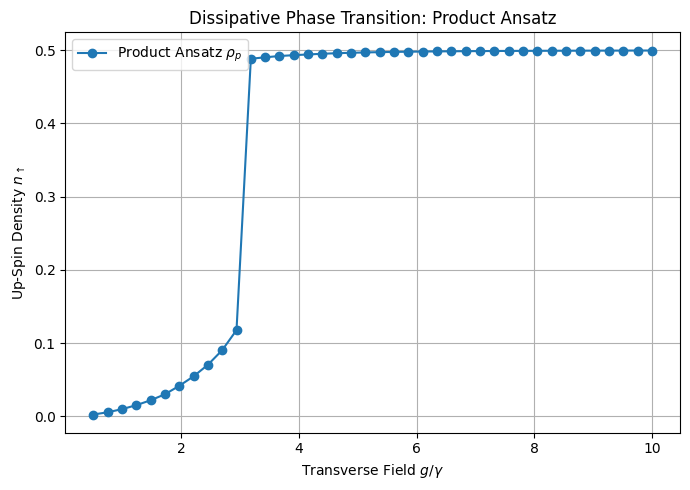

In [20]:
from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Operators
sm, sp = destroy(2), destroy(2).dag()
Pr = sp * sm
Pg = qeye(2) - Pr

sz = Pr - Pg
sx = sm + sp
sy = 1j * (sm - sp)
s0 = qeye(2)
sigma = [sx, sy, sz]

# Parameters
V = 5.0      # Interaction strength
gamma = 1.0  # Decay rate
W_vals = np.linspace(0.5, 10.0, 40)  # Transverse field 

n_up_prod, cost_prod = [], []

def commutator(x, y):
    return x * y - y * x

# PRODUCT STATE ANSATZ 
def cost_product(alpha, W):
    rho_1 = (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.
    rho_2 = (qeye(2) + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2.
    rho_12 = tensor(rho_1, rho_2)

    Hl = W / 2. * (tensor(sx, s0) + tensor(s0, sx))
    Hint = V / 4. * tensor(sz, sz)
    Heff = V / 4. * ((rho_2 * sz).tr() * tensor(sz, s0) +
                     (rho_1 * sz).tr() * tensor(s0, sz))
    H = Hl + Hint + Heff
    L = [tensor(sm, sm)]

    drho = -1j * commutator(H, rho_12)
    for c in L:
        drho += c * rho_12 * c.dag() - 0.5 * (c.dag()*c*rho_12 + rho_12*c.dag()*c)

    return sum(abs(drho.eigenenergies()))

# Optimization 
alpha0 = [-0.1, 0.05, 0.1, -0.1, 0.05, -0.1]

for W in W_vals:
    res_p = minimize(
        cost_product, alpha0, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_p.success:
        alpha_opt = res_p.x
        sz1 = (1. + alpha_opt[2]) / 2.
        sz2 = (1. + alpha_opt[5]) / 2.
        n_avg_p = (sz1 + sz2) / 2
        n_up_prod.append(n_avg_p)
        cost_prod.append(cost_product(alpha_opt, W))
        alpha0 = alpha_opt
    else:
        n_up_prod.append(np.nan)
        cost_prod.append(np.nan)

plt.figure(figsize=(7, 5))
plt.plot(W_vals, n_up_prod, 'o-', label='Product Ansatz $\\rho_p$')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Up-Spin Density $n_\\uparrow$")
plt.title("Dissipative Phase Transition: Product Ansatz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


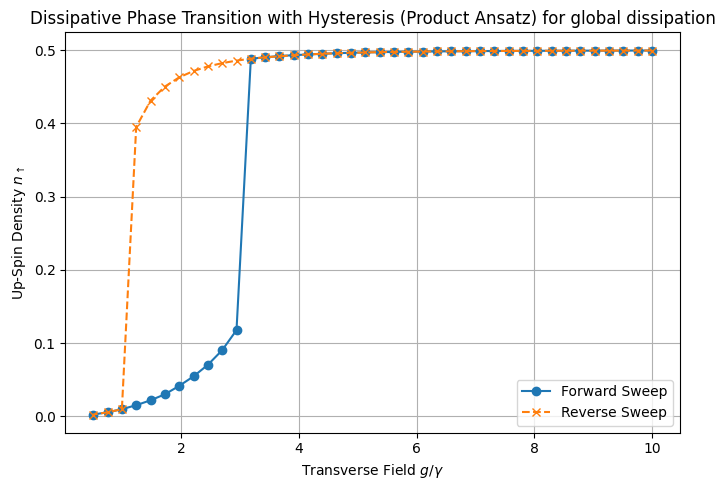

In [30]:
from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Operators
sm, sp = destroy(2), destroy(2).dag()
Pr = sp * sm
Pg = qeye(2) - Pr

sz = Pr - Pg
sx = sm + sp
sy = 1j * (sm - sp)
s0 = qeye(2)
sigma = [sx, sy, sz]

# Parameters
V = 5.0      # Interaction strength
gamma = 1.0  # Decay rate
W_vals = np.linspace(0.5, 10.0, 40)  # Transverse field sweep

# Storage
n_up_prod, cost_prod = [], []
n_up_prod_reverse = []

# --- Helper functions ---
def commutator(x, y):
    return x * y - y * x

# PRODUCT STATE ANSATZ 
def cost_product(alpha, W):
    rho_1 = (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.
    rho_2 = (qeye(2) + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2.
    rho_12 = tensor(rho_1, rho_2)

    Hl = W / 2. * (tensor(sx, s0) + tensor(s0, sx))
    Hint = V / 4. * tensor(sz, sz)
    Heff = V / 4. * ((rho_2 * sz).tr() * tensor(sz, s0) +
                     (rho_1 * sz).tr() * tensor(s0, sz))
    H = Hl + Hint + Heff
    L = [tensor(sm, sm)]

    drho = -1j * commutator(H, rho_12)
    for c in L:
        drho += c * rho_12 * c.dag() - 0.5 * (c.dag()*c*rho_12 + rho_12*c.dag()*c)

    return sum(abs(drho.eigenenergies()))

# Forward Sweep
alpha0 = [-0.1, 0.05, 0.1, -0.1, 0.05, -0.1]
for W in W_vals:
    res_p = minimize(
        cost_product, alpha0, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_p.success:
        alpha_opt = res_p.x
        sz1 = (1. + alpha_opt[2]) / 2.
        sz2 = (1. + alpha_opt[5]) / 2.
        n_avg_p = (sz1 + sz2) / 2
        n_up_prod.append(n_avg_p)
        cost_prod.append(cost_product(alpha_opt, W))
        alpha0 = alpha_opt
    else:
        n_up_prod.append(np.nan)
        cost_prod.append(np.nan)

# Reverse Sweep
alpha0_reverse = alpha_opt.copy()
for W in W_vals[::-1]:
    res_r = minimize(
        cost_product, alpha0_reverse, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_r.success:
        alpha_opt_r = res_r.x
        sz1_r = (1. + alpha_opt_r[2]) / 2.
        sz2_r = (1. + alpha_opt_r[5]) / 2.
        n_avg_r = (sz1_r + sz2_r) / 2
        n_up_prod_reverse.append(n_avg_r)
        alpha0_reverse = alpha_opt_r
    else:
        n_up_prod_reverse.append(np.nan)

# Plot
W_vals_reverse = W_vals[::-1]
plt.figure(figsize=(7, 5))
plt.plot(W_vals, n_up_prod, 'o-', label='Forward Sweep')
plt.plot(W_vals_reverse, n_up_prod_reverse, 'x--', label='Reverse Sweep')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Up-Spin Density $n_\\uparrow$")
plt.title("Dissipative Phase Transition with Hysteresis (Product Ansatz) for global dissipation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


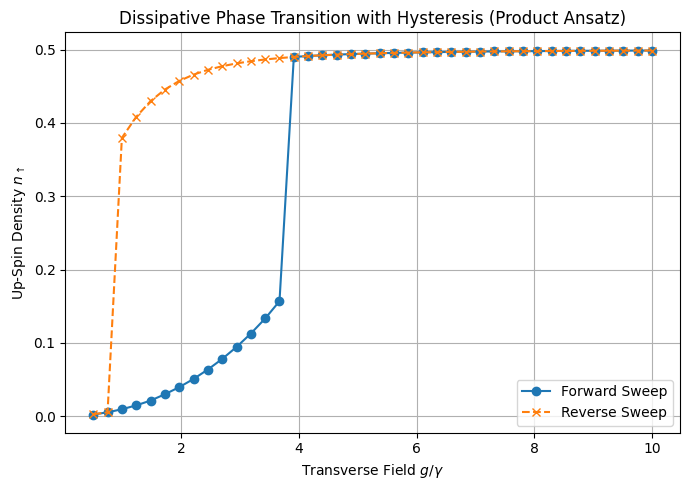

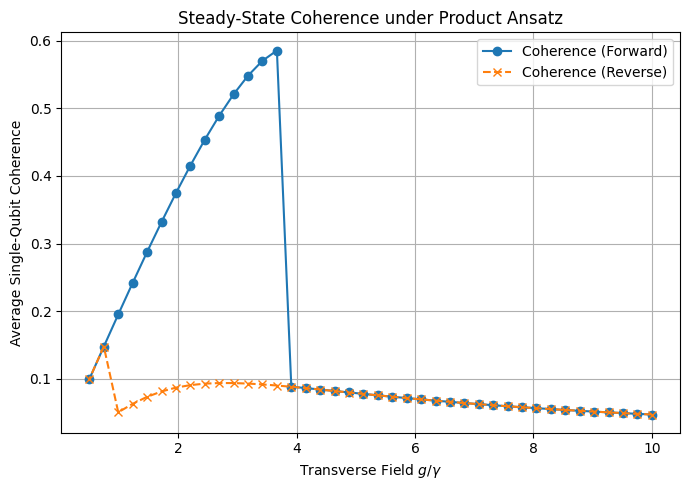

In [58]:
from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Operators
sm, sp = destroy(2), destroy(2).dag()
Pr = sp * sm
Pg = qeye(2) - Pr

sz = Pr - Pg
sx = sm + sp
sy = 1j * (sm - sp)
s0 = qeye(2)
sigma = [sx, sy, sz]

# Parameters
V = 5.0      # Interaction strength
gamma = 1.0  # Decay rate
W_vals = np.linspace(0.5, 10.0, 40)  # Transverse field sweep

# Storage
n_up_prod, cost_prod = [], []
n_up_prod_reverse = []
coh_prod, coh_prod_reverse = [], []

# --- Helper functions ---
def commutator(x, y):
    return x * y - y * x

# PRODUCT STATE ANSATZ 
def cost_product(alpha, W):
    rho_1 = (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.
    rho_2 = (qeye(2) + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2.
    rho_12 = tensor(rho_1, rho_2)

    Hl = W / 2. * (tensor(sx, s0) + tensor(s0, sx))
    Hint = V / 4. * tensor(sz, sz)
    Heff = V / 4. * ((rho_2 * sz).tr() * tensor(sz, s0) +
                     (rho_1 * sz).tr() * tensor(s0, sz))
    H = Hl + Hint + Heff
    L = [tensor(sm, s0)]

    drho = -1j * commutator(H, rho_12)
    for c in L:
        drho += c * rho_12 * c.dag() - 0.5 * (c.dag()*c*rho_12 + rho_12*c.dag()*c)

    return sum(abs(drho.eigenenergies()))

# Forward Sweep
alpha0 = [-0.1, 0.05, 0.1, -0.1, 0.05, -0.1]
for W in W_vals:
    res_p = minimize(
        cost_product, alpha0, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_p.success:
        alpha_opt = res_p.x
        sz1 = (1. + alpha_opt[2]) / 2.
        sz2 = (1. + alpha_opt[5]) / 2.
        n_avg_p = (sz1 + sz2) / 2
        n_up_prod.append(n_avg_p)
        cost_prod.append(cost_product(alpha_opt, W))

        # Coherence calculation
        coh1 = np.sqrt(alpha_opt[0]**2 + alpha_opt[1]**2)
        coh2 = np.sqrt(alpha_opt[3]**2 + alpha_opt[4]**2)
        coh_prod.append((coh1 + coh2) / 2)

        alpha0 = alpha_opt
    else:
        n_up_prod.append(np.nan)
        cost_prod.append(np.nan)
        coh_prod.append(np.nan)

# Reverse Sweep
alpha0_reverse = alpha_opt.copy()
for W in W_vals[::-1]:
    res_r = minimize(
        cost_product, alpha0_reverse, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_r.success:
        alpha_opt_r = res_r.x
        sz1_r = (1. + alpha_opt_r[2]) / 2.
        sz2_r = (1. + alpha_opt_r[5]) / 2.
        n_avg_r = (sz1_r + sz2_r) / 2
        n_up_prod_reverse.append(n_avg_r)

        # Coherence calculation
        coh1_r = np.sqrt(alpha_opt_r[0]**2 + alpha_opt_r[1]**2)
        coh2_r = np.sqrt(alpha_opt_r[3]**2 + alpha_opt_r[4]**2)
        coh_prod_reverse.append((coh1_r + coh2_r) / 2)

        alpha0_reverse = alpha_opt_r
    else:
        n_up_prod_reverse.append(np.nan)
        coh_prod_reverse.append(np.nan)

# Plot: Up-Spin Density
W_vals_reverse = W_vals[::-1]
plt.figure(figsize=(7, 5))
plt.plot(W_vals, n_up_prod, 'o-', label='Forward Sweep')
plt.plot(W_vals_reverse, n_up_prod_reverse, 'x--', label='Reverse Sweep')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Up-Spin Density $n_\\uparrow$")
plt.title("Dissipative Phase Transition with Hysteresis (Product Ansatz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Coherence
plt.figure(figsize=(7, 5))
plt.plot(W_vals, coh_prod, 'o-', label='Coherence (Forward)')
plt.plot(W_vals_reverse, coh_prod_reverse, 'x--', label='Coherence (Reverse)')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Average Single-Qubit Coherence")
plt.title("Steady-State Coherence under Product Ansatz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


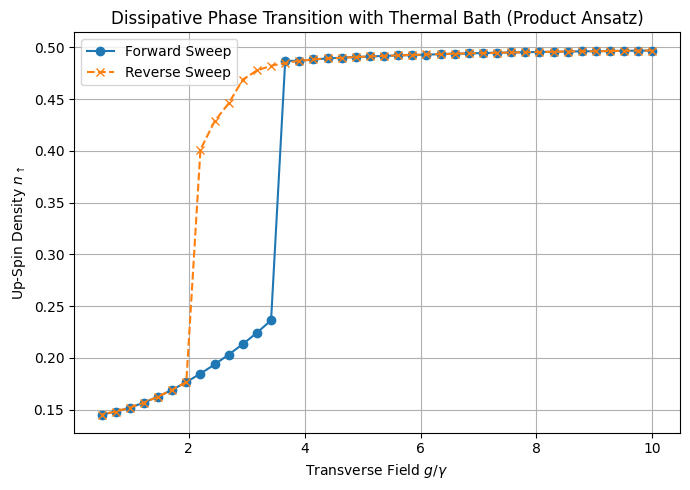

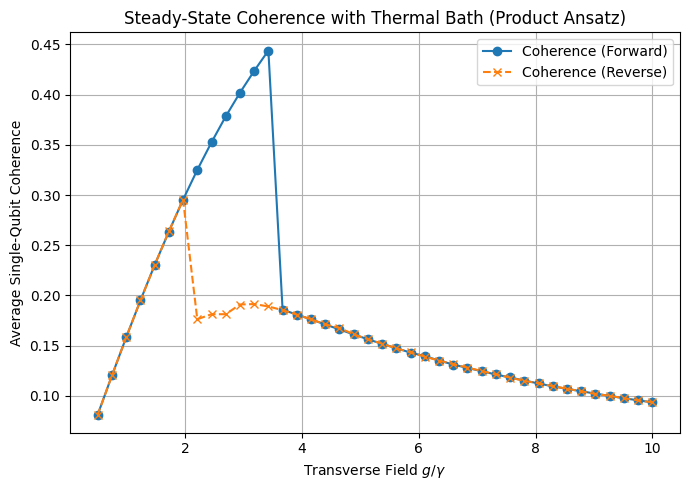

In [52]:
from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Operators
sm, sp = destroy(2), destroy(2).dag()
Pr = sp * sm
Pg = qeye(2) - Pr

sz = Pr - Pg
sx = sm + sp
sy = 1j * (sm - sp)
s0 = qeye(2)
sigma = [sx, sy, sz]

# Parameters
V = 5.0          # Interaction strength
gamma = 1.0      # Decay rate
beta = 0.5       # Inverse temperature
omega = 1.0      # Transition energy
W_vals = np.linspace(0.5, 10.0, 40)  # Transverse field sweep

# Thermal occupation number
n_th = 1.0 / (np.exp(beta * omega) - 1.0)
n_th=0.2
# Storage
n_up_prod, cost_prod = [], []
n_up_prod_reverse = []
coh_prod, coh_prod_reverse = [], []

# Helper function
def commutator(x, y):
    return x * y - y * x

# Product state cost with thermal bath
def cost_product(alpha, W):
    # Single-site reduced density matrices
    rho_1 = (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.
    rho_2 = (qeye(2) + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2.
    rho_12 = tensor(rho_1, rho_2)

    # Hamiltonian
    Hl = W / 2. * (tensor(sx, s0) + tensor(s0, sx))
    Hint = V / 4. * tensor(sz, sz)
    Heff = V / 4. * ((rho_2 * sz).tr() * tensor(sz, s0) +
                     (rho_1 * sz).tr() * tensor(s0, sz))
    H = Hl + Hint + Heff

    # Lindblad operators for thermal bath
    L_down = [np.sqrt(gamma * (1 + n_th)) * tensor(sm, s0),
              np.sqrt(gamma * (1 + n_th)) * tensor(s0, sm)]
    L_up = [np.sqrt(gamma * n_th) * tensor(sp, s0),
            np.sqrt(gamma * n_th) * tensor(s0, sp)]
    L = L_down + L_up

    # Liouvillian evolution
    drho = -1j * commutator(H, rho_12)
    for c in L:
        drho += c * rho_12 * c.dag() - 0.5 * (c.dag()*c*rho_12 + rho_12*c.dag()*c)

    return sum(abs(drho.eigenenergies()))

# Forward Sweep
alpha0 = [-0.1, 0.05, 0.1, -0.1, 0.05, -0.1]
for W in W_vals:
    res_p = minimize(
        cost_product, alpha0, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_p.success:
        alpha_opt = res_p.x
        sz1 = (1. + alpha_opt[2]) / 2.
        sz2 = (1. + alpha_opt[5]) / 2.
        n_avg_p = (sz1 + sz2) / 2
        n_up_prod.append(n_avg_p)
        cost_prod.append(cost_product(alpha_opt, W))

        # Coherence
        coh1 = np.sqrt(alpha_opt[0]**2 + alpha_opt[1]**2)
        coh2 = np.sqrt(alpha_opt[3]**2 + alpha_opt[4]**2)
        coh_prod.append((coh1 + coh2) / 2)

        alpha0 = alpha_opt
    else:
        n_up_prod.append(np.nan)
        cost_prod.append(np.nan)
        coh_prod.append(np.nan)

# Reverse Sweep
alpha0_reverse = alpha_opt.copy()
for W in W_vals[::-1]:
    res_r = minimize(
        cost_product, alpha0_reverse, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_r.success:
        alpha_opt_r = res_r.x
        sz1_r = (1. + alpha_opt_r[2]) / 2.
        sz2_r = (1. + alpha_opt_r[5]) / 2.
        n_avg_r = (sz1_r + sz2_r) / 2
        n_up_prod_reverse.append(n_avg_r)

        # Coherence
        coh1_r = np.sqrt(alpha_opt_r[0]**2 + alpha_opt_r[1]**2)
        coh2_r = np.sqrt(alpha_opt_r[3]**2 + alpha_opt_r[4]**2)
        coh_prod_reverse.append((coh1_r + coh2_r) / 2)

        alpha0_reverse = alpha_opt_r
    else:
        n_up_prod_reverse.append(np.nan)
        coh_prod_reverse.append(np.nan)

# Plot: Up-spin density
W_vals_reverse = W_vals[::-1]
plt.figure(figsize=(7, 5))
plt.plot(W_vals, n_up_prod, 'o-', label='Forward Sweep')
plt.plot(W_vals_reverse, n_up_prod_reverse, 'x--', label='Reverse Sweep')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Up-Spin Density $n_\\uparrow$")
plt.title("Dissipative Phase Transition with Thermal Bath (Product Ansatz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Coherence
plt.figure(figsize=(7, 5))
plt.plot(W_vals, coh_prod, 'o-', label='Coherence (Forward)')
plt.plot(W_vals_reverse, coh_prod_reverse, 'x--', label='Coherence (Reverse)')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Average Single-Qubit Coherence")
plt.title("Steady-State Coherence with Thermal Bath (Product Ansatz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


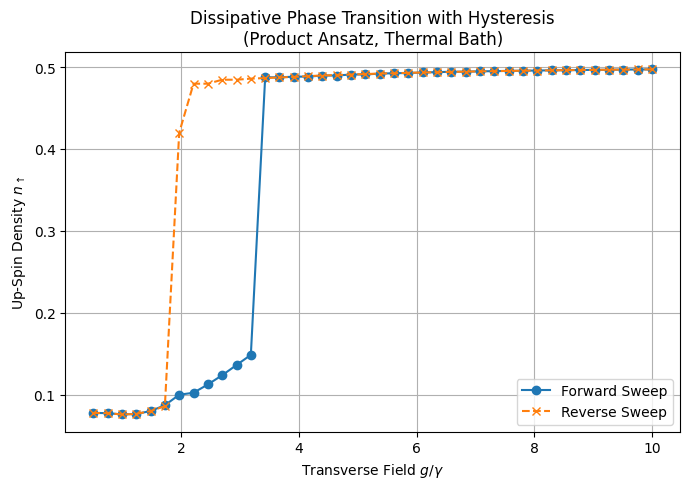

In [48]:
from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Operators
sm, sp = destroy(2), destroy(2).dag()
Pr = sp * sm
Pg = qeye(2) - Pr

sz = Pr - Pg
sx = sm + sp
sy = 1j * (sm - sp)
s0 = qeye(2)
sigma = [sx, sy, sz]

# Parameters
V = 5.0         # Interaction strength
gamma = 1.0     # Coupling to thermal bath
n_th = 0.2      # Mean thermal occupation number
n_c=0.01
W_vals = np.linspace(0.5, 10.0, 40)  # Transverse field sweep

# Storage
n_up_prod, cost_prod = [], []
n_up_prod_reverse = []

# Helper function
def commutator(x, y):
    return x * y - y * x

# --- Cost function with thermal bath ---
def cost_product(alpha, W):
    # Bloch vector to density matrices
    rho_1 = (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.
    rho_2 = (qeye(2) + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2.
    rho_12 = tensor(rho_1, rho_2)

    # Hamiltonian terms
    Hl = W / 2. * (tensor(sx, s0) + tensor(s0, sx))
    Hint = V / 4. * tensor(sz, sz)
    Heff = V / 4. * ((rho_2 * sz).tr() * tensor(sz, s0) +
                     (rho_1 * sz).tr() * tensor(s0, sz))
    H = Hl + Hint + Heff

    # Thermal bath Lindblad operators
    L = []
    for op in [sm, sp]:
        # site 1
        rate1 = np.sqrt(gamma * (1 + n_th)) if op == sm else np.sqrt(gamma * n_th)
        L.append(tensor(rate1 * op, s0))
        # site 2
        rate2 = np.sqrt(gamma * (1 + n_c)) if op == sm else np.sqrt(gamma * n_c)
        L.append(tensor(s0, rate2 * op))

    # Master equation: Lindblad evolution
    drho = -1j * commutator(H, rho_12)
    for c in L:
        drho += c * rho_12 * c.dag() - 0.5 * (c.dag() * c * rho_12 + rho_12 * c.dag() * c)

    # Objective: norm of RHS of master equation (should be 0 for steady state)
    return sum(abs(drho.eigenenergies()))

# --- Forward Sweep ---
alpha0 = [-0.1, 0.05, 0.1, -0.1, 0.05, -0.1]
for W in W_vals:
    res_p = minimize(
        cost_product, alpha0, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_p.success:
        alpha_opt = res_p.x
        sz1 = (1. + alpha_opt[2]) / 2.
        sz2 = (1. + alpha_opt[5]) / 2.
        n_avg_p = (sz1 + sz2) / 2
        n_up_prod.append(n_avg_p)
        cost_prod.append(cost_product(alpha_opt, W))
        alpha0 = alpha_opt
    else:
        n_up_prod.append(np.nan)
        cost_prod.append(np.nan)

# --- Reverse Sweep ---
alpha0_reverse = alpha_opt.copy()
for W in W_vals[::-1]:
    res_r = minimize(
        cost_product, alpha0_reverse, args=(W,), method='SLSQP',
        options={'ftol': 1e-7, 'disp': False, 'maxiter': 500},
        constraints={'type': 'ineq', 'fun': lambda x: (1. - x[0]**2 - x[1]**2 - x[2]**2)/4.}
    )
    if res_r.success:
        alpha_opt_r = res_r.x
        sz1_r = (1. + alpha_opt_r[2]) / 2.
        sz2_r = (1. + alpha_opt_r[5]) / 2.
        n_avg_r = (sz1_r + sz2_r) / 2
        n_up_prod_reverse.append(n_avg_r)
        alpha0_reverse = alpha_opt_r
    else:
        n_up_prod_reverse.append(np.nan)

# --- Plotting ---
W_vals_reverse = W_vals[::-1]
plt.figure(figsize=(7, 5))
plt.plot(W_vals, n_up_prod, 'o-', label='Forward Sweep')
plt.plot(W_vals_reverse, n_up_prod_reverse, 'x--', label='Reverse Sweep')
plt.xlabel("Transverse Field $g/\\gamma$")
plt.ylabel("Up-Spin Density $n_\\uparrow$")
plt.title("Dissipative Phase Transition with Hysteresis\n(Product Ansatz, Thermal Bath)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


W = 0.10, <sz> = -0.9988, cost = 5.0892e-03
W = 0.20, <sz> = -0.9953, cost = 1.9917e-02
W = 0.30, <sz> = -0.9894, cost = 4.4690e-02
W = 0.40, <sz> = -0.9812, cost = 7.9160e-02
W = 0.50, <sz> = -0.9707, cost = 1.2313e-01
W = 0.60, <sz> = -0.9580, cost = 1.7634e-01
W = 0.70, <sz> = -0.9430, cost = 2.3847e-01
W = 0.80, <sz> = -0.9261, cost = 3.0907e-01
W = 0.90, <sz> = -0.9072, cost = 3.8762e-01
W = 1.00, <sz> = -0.8866, cost = 4.7346e-01
W = 1.10, <sz> = -0.8645, cost = 5.6578e-01
W = 1.20, <sz> = -0.8409, cost = 6.6368e-01
W = 1.30, <sz> = -0.8160, cost = 7.6611e-01
W = 1.40, <sz> = -0.7901, cost = 8.7194e-01
W = 1.50, <sz> = -0.7630, cost = 9.7993e-01
W = 1.60, <sz> = -0.7344, cost = 1.0888e+00
W = 1.70, <sz> = -0.7041, cost = 1.1971e+00
W = 1.80, <sz> = -0.6713, cost = 1.3032e+00
W = 1.90, <sz> = -0.6337, cost = 1.4053e+00
W = 2.00, <sz> = -0.1161, cost = 9.7548e-01
W = 2.10, <sz> = -0.1056, cost = 9.4497e-01
W = 2.20, <sz> = -0.0969, cost = 9.1578e-01
W = 2.30, <sz> = -0.0892, cost =

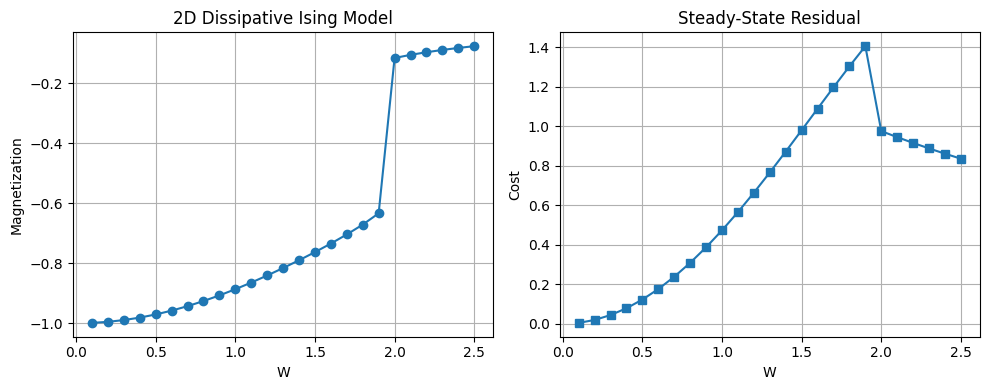

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import minimize
from itertools import product

# Pauli matrices
sm = destroy(2)
sp = sm.dag()
sx = sm + sp
sy = 1j * (sm - sp)
sz = sp * sm - (qeye(2) - sp * sm)
s0 = qeye(2)

# Lattice size
L = 3  # 3x3 lattice
N = L * L

# Parameters
V = 1.0     # Interaction strength
gamma = 1.0 # Dissipation rate
Ws = np.linspace(0.1, 2.5, 25)  # Transverse field sweep

# Helper: get 2D lattice neighbors with periodic boundary
def get_neighbors_2D(L):
    neighbors = []
    for x in range(L):
        for y in range(L):
            i = x + L * y
            for dx, dy in [(1, 0), (0, 1)]:  # Right and down
                jx, jy = (x + dx) % L, (y + dy) % L
                j = jx + L * jy
                neighbors.append((i, j))
    return neighbors

neighbor_pairs = get_neighbors_2D(L)

# Construct variational product state for all sites
def rho_site(alpha):
    return (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.

# Build global rho as a product state
def tensor_product_state(alpha):
    return tensor([rho_site(alpha)] * N)

# Construct Hamiltonian
def hamiltonian(W, alpha):
    rho_loc = rho_site(alpha)
    H = 0

    # Transverse field
    for i in range(N):
        ops = [s0]*N
        ops[i] = sx
        H += (W / 2) * tensor(ops)

    # Ising ZZ interaction
    for i, j in neighbor_pairs:
        ops_i = [s0]*N
        ops_j = [s0]*N
        ops_i[i] = sz
        ops_j[j] = sz
        H += (V / 4) * tensor(ops_i) * tensor(ops_j)

    return H

# Lindblad dissipators
def lindblad_terms(rho):
    dot_rho = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sm
        c = tensor(ops)
        dot_rho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    return gamma * dot_rho

# Cost function: Tr|dot_rho|
def cost_fn(alpha, W):
    rho = tensor_product_state(alpha)
    H = hamiltonian(W, alpha)
    drho = -1j * (H * rho - rho * H) + lindblad_terms(rho)
    return np.sum(np.abs(drho.eigenenergies()))

# Scan over W and collect <sz> and cost
magnetizations = []
cost_values = []
alpha0 = [0.0, 0.0, 0.0]

for W in Ws:
    res = minimize(lambda a: cost_fn(a, W), alpha0, method='SLSQP',
                   constraints={'type': 'ineq', 'fun': lambda x: 1. - x[0]**2 - x[1]**2 - x[2]**2},
                   options={'ftol': 1e-6, 'disp': False})

    if res.success:
        alpha_opt = res.x
        rho = rho_site(alpha_opt)
        sz_val = (rho * sz).tr().real
        magnetizations.append(sz_val)
        cost_values.append(cost_fn(alpha_opt, W))
        alpha0 = alpha_opt  # warm start
        print(f"W = {W:.2f}, <sz> = {sz_val:.4f}, cost = {cost_values[-1]:.4e}")
    else:
        magnetizations.append(np.nan)
        cost_values.append(np.nan)
        print(f"W = {W:.2f} — optimization failed")

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(Ws, magnetizations, 'o-', label=r"$\langle \sigma^z \rangle$")
plt.xlabel("W")
plt.ylabel("Magnetization")
plt.title("2D Dissipative Ising Model")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Ws, cost_values, 's-', label=r"$\mathrm{Tr}|\dot{\rho}|$")
plt.xlabel("W")
plt.ylabel("Cost")
plt.title("Steady-State Residual")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import minimize
from itertools import product

# Pauli matrices
sm = destroy(2)
sp = sm.dag()
sx = sm + sp
sy = 1j * (sm - sp)
sz = sp * sm - (qeye(2) - sp * sm)
s0 = qeye(2)

# Lattice size
L = 2  # 2x2 lattice
N = L * L

# Parameters
V = 1.0     # Interaction strength
gamma = 1.0 # Dissipation rate
Ws = np.linspace(0.1, 2.5, 25)  # Transverse field sweep

# Helper: get 2D lattice neighbors with periodic boundary
def get_neighbors_2D(L):
    neighbors = []
    for x in range(L):
        for y in range(L):
            i = x + L * y
            for dx, dy in [(1, 0), (0, 1)]:  # Right and down
                jx, jy = (x + dx) % L, (y + dy) % L
                j = jx + L * jy
                neighbors.append((i, j))
    return neighbors

neighbor_pairs = get_neighbors_2D(L)

# Construct variational product state for all sites
def rho_site(alpha):
    return (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.

# Build global rho as a product state
def tensor_product_state(alpha):
    return tensor([rho_site(alpha)] * N)

# Construct Hamiltonian
def hamiltonian(W, alpha):
    H = 0

    # Transverse field
    for i in range(N):
        ops = [s0]*N
        ops[i] = sx
        H += (W / 2) * tensor(ops)

    # Ising ZZ interaction
    for i, j in neighbor_pairs:
        ops_i = [s0]*N
        ops_j = [s0]*N
        ops_i[i] = sz
        ops_j[j] = sz
        H += (V / 4) * tensor(ops_i) * tensor(ops_j)

    return H

# Lindblad dissipators
def lindblad_terms(rho):
    dot_rho = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sp
        c = tensor(ops)
        dot_rho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    return gamma * dot_rho

# Cost function: Tr|dot_rho|
def cost_fn(alpha, W):
    rho = tensor_product_state(alpha)
    H = hamiltonian(W, alpha)
    drho = -1j * (H * rho - rho * H) + lindblad_terms(rho)
    return np.sum(np.abs(drho.eigenenergies()))

# Perform sweep
def perform_sweep(Ws, alpha0_init):
    magnetizations = []
    cost_values = []
    alpha0 = alpha0_init.copy()

    for W in Ws:
        res = minimize(lambda a: cost_fn(a, W), alpha0, method='SLSQP',
                       constraints={'type': 'ineq', 'fun': lambda x: 1. - x[0]**2 - x[1]**2 - x[2]**2},
                       options={'ftol': 1e-6, 'disp': False})

        if res.success:
            alpha_opt = res.x
            rho = rho_site(alpha_opt)
            sz_val = (rho * sz).tr().real
            magnetizations.append(sz_val)
            cost_values.append(cost_fn(alpha_opt, W))
            alpha0 = alpha_opt  # warm start for next W
            print(f"W = {W:.2f}, <sz> = {sz_val:.4f}, cost = {cost_values[-1]:.4e}")
        else:
            magnetizations.append(np.nan)
            cost_values.append(np.nan)
            print(f"W = {W:.2f} — optimization failed")
    
    return magnetizations, cost_values, alpha0

# ----------- Run sweeps ----------- #

print("Forward sweep:")
magnetizations_fwd, cost_values_fwd, last_alpha_fwd = perform_sweep(Ws, alpha0_init=[0.0, 0.0, 0.0])

print("\nReverse sweep:")
magnetizations_rev, cost_values_rev, _ = perform_sweep(Ws[::-1], alpha0_init=last_alpha_fwd)

# ----------- Plot results ----------- #

plt.figure(figsize=(12, 5))

# Magnetization plot
plt.subplot(1, 2, 1)
plt.plot(Ws, magnetizations_fwd, 'o-', label='Forward Sweep')
plt.plot(Ws[::-1], magnetizations_rev, 's--', label='Reverse Sweep')
plt.xlabel("W")
plt.ylabel(r"$\langle \sigma^z \rangle$")
plt.title("Magnetization")
plt.grid(True)
plt.legend()

# # Cost plot
# plt.subplot(1, 2, 2)
# plt.plot(Ws, cost_values_fwd, 'o-', label='Forward Sweep')
# plt.plot(Ws[::-1], cost_values_rev, 's--', label='Reverse Sweep')
# plt.xlabel("W")
# plt.ylabel(r"$\mathrm{Tr}|\dot{\rho}|$")
# plt.title("Steady-State Residual")
# plt.grid(True)
# plt.legend()

plt.tight_layout()
plt.show()


# Collective Dephasing Variational Steady state

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import minimize

# Pauli matrices
sm = destroy(2)
sp = sm.dag()
sx = sm + sp
sy = 1j * (sm - sp)
sz = sp * sm - (qeye(2) - sp * sm)
s0 = qeye(2)

# Lattice size
L = 3  # 3x3 lattice
N = L * L

# Parameters
V = 1.0     # Interaction strength
gamma = 1.0 # Collective dephasing rate
Ws = np.linspace(0.1, 2.5, 25)  # Transverse field sweep

# Helper: get 2D lattice neighbors with periodic boundary
def get_neighbors_2D(L):
    neighbors = []
    for x in range(L):
        for y in range(L):
            i = x + L * y
            for dx, dy in [(1, 0), (0, 1)]:  # Right and down
                jx, jy = (x + dx) % L, (y + dy) % L
                j = jx + L * jy
                neighbors.append((i, j))
    return neighbors

neighbor_pairs = get_neighbors_2D(L)

# Single-site density matrix
def rho_site(alpha):
    return (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.

# Global tensor product state
def tensor_product_state(alpha):
    return tensor([rho_site(alpha)] * N)

# Hamiltonian: Transverse field + Ising interaction
def hamiltonian(W):
    H = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sx
        H += (W / 2) * tensor(ops)
    for i, j in neighbor_pairs:
        ops_i = [s0]*N
        ops_j = [s0]*N
        ops_i[i] = sz
        ops_j[j] = sz
        H += (V / 4) * tensor(ops_i) * tensor(ops_j)
    return H

# Collective dissipation Lindblad term
def lindblad_terms_collective(rho):
    # Build global L = sum_i sm_i
    L_op = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sp
        L_op += tensor(ops)
    
    # Dissipator D[L](rho)
    dot_rho = L_op * rho * L_op.dag() - 0.5 * (L_op.dag() * L_op * rho + rho * L_op.dag() * L_op)
    return gamma * dot_rho

# Cost function: Tr|dot{rho}|
def cost_fn(alpha, W):
    rho = tensor_product_state(alpha)
    H = hamiltonian(W)
    drho = -1j * (H * rho - rho * H) + lindblad_terms_collective(rho)
    return np.sum(np.abs(drho.eigenenergies()))

# Main scan over W
magnetizations = []
cost_values = []
alpha0 = [0.0, 0.0, 0.0]  # Initial guess

for W in Ws:
    res = minimize(lambda a: cost_fn(a, W), alpha0, method='SLSQP',
                   constraints={'type': 'ineq', 'fun': lambda x: 1. - x[0]**2 - x[1]**2 - x[2]**2},
                   options={'ftol': 1e-6, 'disp': False})
    
    if res.success:
        alpha_opt = res.x
        rho = rho_site(alpha_opt)
        sz_val = (rho * sz).tr().real
        magnetizations.append(sz_val)
        cost_values.append(cost_fn(alpha_opt, W))
        alpha0 = alpha_opt  # Warm start
        print(f"W = {W:.2f}, <sz> = {sz_val:.4f}, cost = {cost_values[-1]:.4e}")
    else:
        magnetizations.append(np.nan)
        cost_values.append(np.nan)
        print(f"W = {W:.2f} — optimization failed")

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(Ws, magnetizations, 'o-', label=r"$\langle \sigma^z \rangle$")
plt.xlabel("W")
plt.ylabel("Magnetization")
plt.title("2D Dissipative Ising Model with Collective Dephasing")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Ws, cost_values, 's-', label=r"$\mathrm{Tr}|\dot{\rho}|$")
plt.xlabel("W")
plt.ylabel("Cost")
plt.title("Steady-State Residual")
plt.grid(True)

plt.tight_layout()
plt.show()


W = 0.10, <sz> = 0.2305, cost = 2.2424e+00


Forward sweep:
W = 0.10, <sz> = -0.9994, cost = 2.9301e-03
W = 0.20, <sz> = -0.9975, cost = 1.1700e-02
W = 0.30, <sz> = -0.9944, cost = 2.6251e-02
W = 0.40, <sz> = -0.9901, cost = 4.6492e-02
W = 0.50, <sz> = -0.9845, cost = 7.2299e-02
W = 0.60, <sz> = -0.9778, cost = 1.0352e-01
W = 0.70, <sz> = -0.9700, cost = 1.3996e-01
W = 0.80, <sz> = -0.9610, cost = 1.8144e-01
W = 0.90, <sz> = -0.9510, cost = 2.2770e-01
W = 1.00, <sz> = -0.9399, cost = 2.7852e-01
W = 1.10, <sz> = -0.9280, cost = 3.3360e-01
W = 1.20, <sz> = -0.9150, cost = 3.9267e-01
W = 1.30, <sz> = -0.9013, cost = 4.5541e-01
W = 1.40, <sz> = -0.8868, cost = 5.2150e-01
W = 1.50, <sz> = -0.8714, cost = 5.9061e-01
W = 1.60, <sz> = -0.8554, cost = 6.6237e-01
W = 1.70, <sz> = -0.8387, cost = 7.3644e-01
W = 1.80, <sz> = -0.8213, cost = 8.1243e-01
W = 1.90, <sz> = -0.8033, cost = 8.8996e-01
W = 2.00, <sz> = -0.7846, cost = 9.6862e-01
W = 2.10, <sz> = -0.7651, cost = 1.0480e+00
W = 2.20, <sz> = -0.7447, cost = 1.1276e+00
W = 2.30, <sz> = 

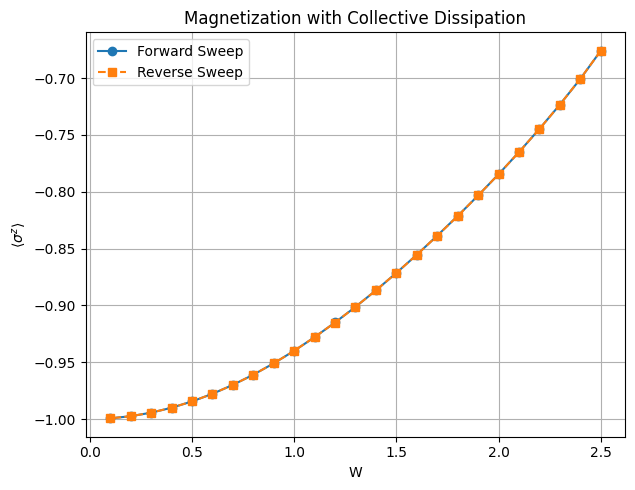

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import minimize

# Pauli matrices
sm = destroy(2)
sp = sm.dag()
sx = sm + sp
sy = 1j * (sm - sp)
sz = sp * sm - (qeye(2) - sp * sm)
s0 = qeye(2)

# Lattice size
L = 2  # 2x2 lattice
N = L * L

# Parameters
V = 1.0     # Interaction strength
gamma = 1.0 # Dissipation rate
Ws = np.linspace(0.1, 2.5, 25)  # Transverse field sweep

# Helper: get 2D lattice neighbors with periodic boundary
def get_neighbors_2D(L):
    neighbors = []
    for x in range(L):
        for y in range(L):
            i = x + L * y
            for dx, dy in [(1, 0), (0, 1)]:  # Right and down
                jx, jy = (x + dx) % L, (y + dy) % L
                j = jx + L * jy
                neighbors.append((i, j))
    return neighbors

neighbor_pairs = get_neighbors_2D(L)

# Construct variational product state for all sites
def rho_site(alpha):
    return (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2.

def tensor_product_state(alpha):
    return tensor([rho_site(alpha)] * N)

def hamiltonian(W, alpha):
    H = 0

    # Transverse field
    for i in range(N):
        ops = [s0]*N
        ops[i] = sx
        H += (W / 2) * tensor(ops)

    # Ising ZZ interaction
    for i, j in neighbor_pairs:
        ops_i = [s0]*N
        ops_j = [s0]*N
        ops_i[i] = sz
        ops_j[j] = sz
        H += (V / 4) * tensor(ops_i) * tensor(ops_j)

    return H

# Collective Lindblad term
def lindblad_terms_collective(rho):
    # Build collective lowering operator C = sum_i sigma_i^-
    C_ops = [s0]*N
    C = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sm
        C += tensor(ops)
    dot_rho = C * rho * C.dag() - 0.5 * (C.dag() * C * rho + rho * C.dag() * C)
    return gamma * dot_rho

# Cost function: Tr|dot_rho|
def cost_fn(alpha, W):
    rho = tensor_product_state(alpha)
    H = hamiltonian(W, alpha)
    drho = -1j * (H * rho - rho * H) + lindblad_terms_collective(rho)
    return np.sum(np.abs(drho.eigenenergies()))

def perform_sweep(Ws, alpha0_init):
    magnetizations = []
    cost_values = []
    alpha0 = alpha0_init.copy()

    for W in Ws:
        res = minimize(lambda a: cost_fn(a, W), alpha0, method='SLSQP',
                       constraints={'type': 'ineq', 'fun': lambda x: 1. - x[0]**2 - x[1]**2 - x[2]**2},
                       options={'ftol': 1e-6, 'disp': False})

        if res.success:
            alpha_opt = res.x
            rho = rho_site(alpha_opt)
            sz_val = (rho * sz).tr().real
            magnetizations.append(sz_val)
            cost_values.append(cost_fn(alpha_opt, W))
            alpha0 = alpha_opt  # warm start
            print(f"W = {W:.2f}, <sz> = {sz_val:.4f}, cost = {cost_values[-1]:.4e}")
        else:
            magnetizations.append(np.nan)
            cost_values.append(np.nan)
            print(f"W = {W:.2f} — optimization failed")
    
    return magnetizations, cost_values, alpha0

# ----------- Run sweeps ----------- #

print("Forward sweep:")
magnetizations_fwd, cost_values_fwd, last_alpha_fwd = perform_sweep(Ws, alpha0_init=[0.0, 0.0, 0.0])

print("\nReverse sweep:")
magnetizations_rev, cost_values_rev, _ = perform_sweep(Ws[::-1], alpha0_init=last_alpha_fwd)

# ----------- Plot results ----------- #

plt.figure(figsize=(12, 5))

# Magnetization plot
plt.subplot(1, 2, 1)
plt.plot(Ws, magnetizations_fwd, 'o-', label='Forward Sweep')
plt.plot(Ws[::-1], magnetizations_rev, 's--', label='Reverse Sweep')
plt.xlabel("W")
plt.ylabel(r"$\langle \sigma^z \rangle$")
plt.title("Magnetization with Collective Dissipation")
plt.grid(True)
plt.legend()

# # Cost plot
# plt.subplot(1, 2, 2)
# plt.plot(Ws, cost_values_fwd, 'o-', label='Forward Sweep')
# plt.plot(Ws[::-1], cost_values_rev, 's--', label='Reverse Sweep')
# plt.xlabel("W")
# plt.ylabel(r"$\mathrm{Tr}|\dot{\rho}|$")
# plt.title("Steady-State Residual")
# plt.grid(True)
# plt.legend()

plt.tight_layout()
plt.show()


# McLachlan  Principle based variational Steady State

W = 0.10, <sz> = 0.0000, cost = 0.0000e+00
W = 0.20, <sz> = 0.0000, cost = 0.0000e+00
W = 0.30, <sz> = 0.0000, cost = 0.0000e+00
W = 0.40, <sz> = 0.0000, cost = 0.0000e+00
W = 0.50, <sz> = 0.0000, cost = 0.0000e+00
W = 0.60, <sz> = 0.0000, cost = 0.0000e+00
W = 0.70, <sz> = 0.0000, cost = 0.0000e+00
W = 0.80, <sz> = 0.0000, cost = 0.0000e+00
W = 0.90, <sz> = 0.0000, cost = 0.0000e+00
W = 1.00, <sz> = 0.0000, cost = 0.0000e+00
W = 1.10, <sz> = 0.0000, cost = 0.0000e+00
W = 1.20, <sz> = 0.0000, cost = 0.0000e+00
W = 1.30, <sz> = 0.0000, cost = 0.0000e+00
W = 1.40, <sz> = 0.0000, cost = 0.0000e+00
W = 1.50, <sz> = 0.0000, cost = 0.0000e+00
W = 1.60, <sz> = 0.0000, cost = 0.0000e+00
W = 1.70, <sz> = 0.0000, cost = 0.0000e+00
W = 1.80, <sz> = 0.0000, cost = 0.0000e+00
W = 1.90, <sz> = 0.0000, cost = 0.0000e+00
W = 2.00, <sz> = 0.0000, cost = 0.0000e+00
W = 2.10, <sz> = 0.0000, cost = 0.0000e+00
W = 2.20, <sz> = 0.0000, cost = 0.0000e+00
W = 2.30, <sz> = 0.0000, cost = 0.0000e+00
W = 2.40, <

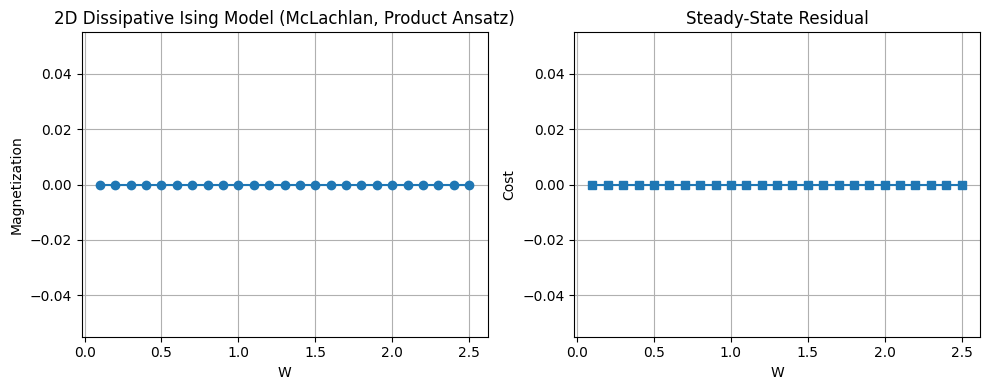

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import minimize

# Pauli matrices
sm = destroy(2)
sp = sm.dag()
sx = sm + sp
sy = 1j * (sm - sp)
sz = sp * sm - (qeye(2) - sp * sm)
s0 = qeye(2)

# Lattice size
L = 3  # 3x3 lattice
N = L * L

# Parameters
V = 1.0     # Interaction strength
gamma = 1.0 # Dissipation rate
Ws = np.linspace(0.1, 2.5, 25)  # Transverse field sweep

# Helper: get 2D lattice neighbors with periodic boundary
def get_neighbors_2D(L):
    neighbors = []
    for x in range(L):
        for y in range(L):
            i = x + L * y
            for dx, dy in [(1, 0), (0, 1)]:
                jx, jy = (x + dx) % L, (y + dy) % L
                j = jx + L * jy
                neighbors.append((i, j))
    return neighbors

neighbor_pairs = get_neighbors_2D(L)

# Build product state
def rho_site(alpha):
    return (qeye(2) + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2

def tensor_product_state(alpha):
    return tensor([rho_site(alpha)] * N)

# Hamiltonian
def hamiltonian(W):
    H = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sx
        H += (W/2) * tensor(ops)
    for i, j in neighbor_pairs:
        ops_i = [s0]*N
        ops_j = [s0]*N
        ops_i[i] = sz
        ops_j[j] = sz
        H += (V/4) * tensor(ops_i) * tensor(ops_j)
    return H

# Lindblad terms (local decay)
def lindblad_terms(rho):
    dot_rho = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sm
        c = tensor(ops)
        dot_rho += c*rho*c.dag() - 0.5*(c.dag()*c*rho + rho*c.dag()*c)
    return gamma * dot_rho

# McLachlan cost function
def mclachlan_cost_fn(alpha, W):
    rho = tensor_product_state(alpha)
    H = hamiltonian(W)
    drho = -1j*(H*rho - rho*H) + lindblad_terms(rho)

    # Derivatives ∂ρ/∂α
    derivs = []
    for pauli in [sx, sy, sz]:
        single_site_deriv = (pauli / 2)
        deriv = tensor([single_site_deriv] * N)
        derivs.append(deriv)

    cost = 0
    for d in derivs:
        overlap = (d.dag() * drho).tr()
        cost += np.abs(overlap)**2
    return cost.real

# Main scan over W
magnetizations = []
cost_values = []
alpha0 = [0.0, 0.0, 0.0]  # Initial guess: Bloch vector

for W in Ws:
    res = minimize(lambda a: mclachlan_cost_fn(a, W), alpha0, method='SLSQP',
                   constraints={'type': 'ineq', 'fun': lambda x: 1. - np.sum(x**2)},
                   options={'ftol': 1e-6, 'disp': False})
    
    if res.success:
        alpha_opt = res.x
        rho = rho_site(alpha_opt)
        sz_val = (rho * sz).tr().real
        magnetizations.append(sz_val)
        cost_values.append(mclachlan_cost_fn(alpha_opt, W))
        alpha0 = alpha_opt  # warm start
        print(f"W = {W:.2f}, <sz> = {sz_val:.4f}, cost = {cost_values[-1]:.4e}")
    else:
        magnetizations.append(np.nan)
        cost_values.append(np.nan)
        print(f"W = {W:.2f} — optimization failed")

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(Ws, magnetizations, 'o-', label=r"$\langle \sigma^z \rangle$")
plt.xlabel("W")
plt.ylabel("Magnetization")
plt.title("2D Dissipative Ising Model (McLachlan, Product Ansatz)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Ws, cost_values, 's-', label=r"McLachlan Cost")
plt.xlabel("W")
plt.ylabel("Cost")
plt.title("Steady-State Residual")
plt.grid(True)

plt.tight_layout()
plt.show()


W = 0.10


/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/4266383705.py:93: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rho = sum(a * b for a, b in zip(alpha, basis))
/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/4266383705.py:126: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rho_kry = sum(a * b for a, b in zip(res_kry.x, krylov_basis))


W = 0.27
W = 0.44
W = 0.61
W = 0.79
W = 0.96
W = 1.13
W = 1.30
W = 1.47
W = 1.64
W = 1.81
W = 1.99
W = 2.16
W = 2.33
W = 2.50


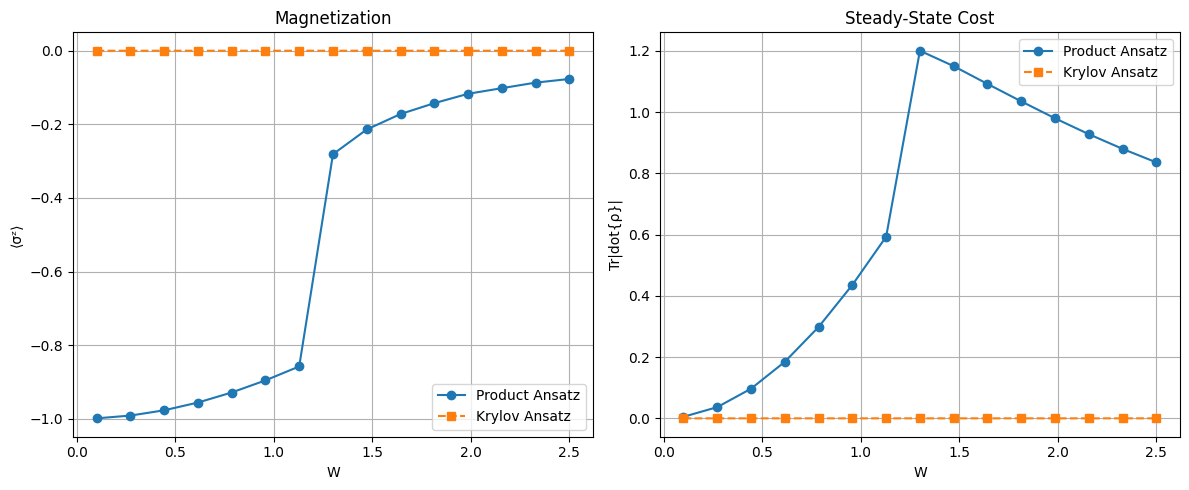

In [70]:
# Krylov vs Product Ansatz for 2D Dissipative Ising Model

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import minimize

# Parameters
L = 3  # 3x3 lattice
N = L * L
V = 1.0
gamma = 1.0
krylov_dim = 10
Ws = np.linspace(0.1, 2.5, 15)

# Pauli operators
sm = destroy(2)
sp = sm.dag()
sx = sm + sp
sy = 1j * (sm - sp)
sz = sp * sm - (qeye(2) - sp * sm)
s0 = qeye(2)

# 2D neighbor list (periodic boundary)
def get_neighbors_2D(L):
    neighbors = []
    for x in range(L):
        for y in range(L):
            i = x + L * y
            for dx, dy in [(1, 0), (0, 1)]:
                jx, jy = (x + dx) % L, (y + dy) % L
                j = jx + L * jy
                neighbors.append((i, j))
    return neighbors

neighbor_pairs = get_neighbors_2D(L)

# Build product state ansatz

def rho_site(alpha):
    return (s0 + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2

def tensor_product_state(alpha):
    return tensor([rho_site(alpha)] * N)

def hamiltonian(W):
    H = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sx
        H += (W/2) * tensor(ops)
    for i, j in neighbor_pairs:
        ops_i = [s0]*N
        ops_j = [s0]*N
        ops_i[i] = sz
        ops_j[j] = sz
        H += (V / 4) * tensor(ops_i) * tensor(ops_j)
    return H

def lindblad_terms(rho):
    dot_rho = 0
    for i in range(N):
        ops = [s0]*N
        ops[i] = sm
        c = tensor(ops)
        dot_rho += c * rho * c.dag() - 0.5 * (c.dag()*c*rho + rho*c.dag()*c)
    return gamma * dot_rho

def cost_fn_product(alpha, W):
    rho = tensor_product_state(alpha)
    H = hamiltonian(W)
    drho = -1j * (H * rho - rho * H) + lindblad_terms(rho)
    return np.sum(np.abs(drho.eigenenergies()))

# Krylov methods

def frob_norm(rho):
    return np.sqrt((rho.dag() * rho).tr().real)

def build_krylov_basis(H, rho0, dim):
    basis = [rho0 / frob_norm(rho0)]
    for _ in range(1, dim):
        v = -1j * (H * basis[-1] - basis[-1] * H) + lindblad_terms(basis[-1])
        for b in basis:
            v -= (b.dag() * v).tr().real * b
        norm = frob_norm(v)
        if norm < 1e-10:
            break
        basis.append(v / norm)
    return basis

def krylov_cost_fn(alpha, basis, H):
    rho = sum(a * b for a, b in zip(alpha, basis))
    drho = -1j * (H * rho - rho * H) + lindblad_terms(rho)
    return np.sum(np.abs(drho.eigenenergies()))

# Main scan
mag_prod, cost_prod = [], []
mag_kry, cost_kry = [], []

for W in Ws:
    print(f"W = {W:.2f}")
    H = hamiltonian(W)

    # --- Product Ansatz ---
    alpha0 = np.zeros(3)
    res_prod = minimize(lambda a: cost_fn_product(a, W), alpha0,
                        method='SLSQP', constraints={'type': 'ineq', 'fun': lambda x: 1. - x[0]**2 - x[1]**2 - x[2]**2},
                        options={'ftol': 1e-6})
    if res_prod.success:
        rho_site_opt = rho_site(res_prod.x)
        sz_val = (rho_site_opt * sz).tr().real
        mag_prod.append(sz_val)
        cost_prod.append(cost_fn_product(res_prod.x, W))
    else:
        mag_prod.append(np.nan)
        cost_prod.append(np.nan)

    # --- Krylov Ansatz ---
    basis_states = [basis(2, 1) if i == N//2 else basis(2, 0) for i in range(N)]
    rho0 = tensor(basis_states).proj()
    krylov_basis = build_krylov_basis(H, rho0, krylov_dim)
    alpha_k0 = np.random.randn(len(krylov_basis)) * 0.1
    res_kry = minimize(lambda a: krylov_cost_fn(a, krylov_basis, H), alpha_k0,
                       method='SLSQP', options={'ftol': 1e-6})
    rho_kry = sum(a * b for a, b in zip(res_kry.x, krylov_basis))
    mag = np.mean([(rho_kry * op_on_site(sz, i, N)).tr().real for i in range(N)])
    cost = krylov_cost_fn(res_kry.x, krylov_basis, H)
    mag_kry.append(mag)
    cost_kry.append(cost)

# Plot comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(Ws, mag_prod, 'o-', label='Product Ansatz')
plt.plot(Ws, mag_kry, 's--', label='Krylov Ansatz')
plt.xlabel("W")
plt.ylabel("⟨σᶻ⟩")
plt.title("Magnetization")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Ws, cost_prod, 'o-', label='Product Ansatz')
plt.plot(Ws, cost_kry, 's--', label='Krylov Ansatz')
plt.xlabel("W")
plt.ylabel("Tr|dot{ρ}|")
plt.title("Steady-State Cost")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- W = 0.00 ---


/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/3101583180.py:56: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_n = sum(op_on_site(Pr, i, N) for i in range(N))
/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/3101583180.py:88: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rho = sum(a * b for a, b in zip(alpha, basis))
/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/3101583180.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rho_kry = sum(a * b for a, b in zip(res_kry.x, krylov_basis))



--- W = 0.09 ---

--- W = 0.18 ---

--- W = 0.27 ---

--- W = 0.36 ---

--- W = 0.44 ---

--- W = 0.53 ---

--- W = 0.62 ---

--- W = 0.71 ---

--- W = 0.80 ---


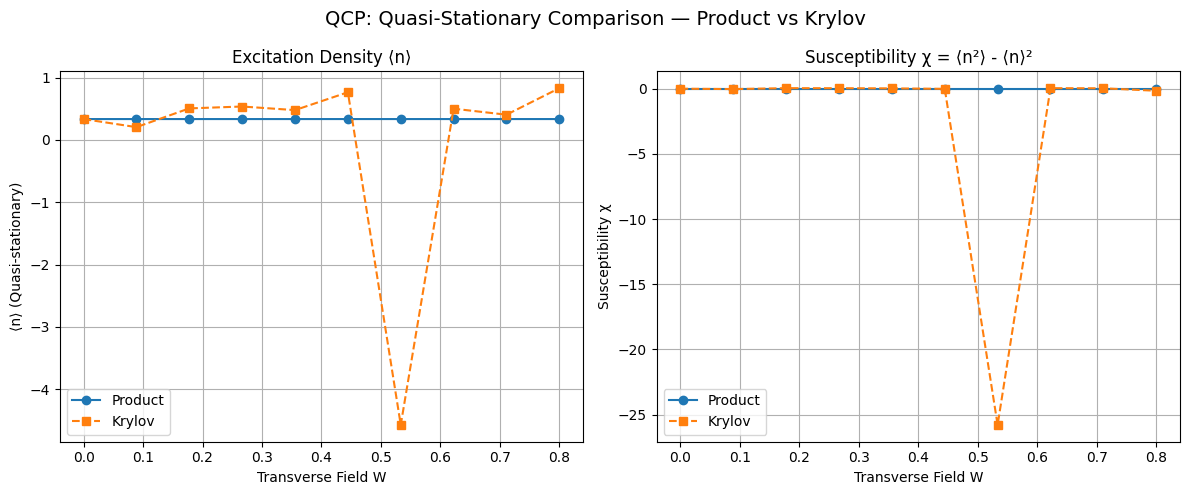

In [95]:
from qutip import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


np.random.seed(42)

# Parameters
gamma = 0.1
W_list = np.linspace(0.0, 0.8, 10)
krylov_dim = 10
N = 3

# Qubit operators
sm = destroy(2)
sp = sm.dag()
sx = sm + sp
sy = 1j * (sm - sp)
sz = sp * sm - (qeye(2) - sp * sm)
Pr = sp * sm
id2 = qeye(2)

# Tensor op at site i
def op_on_site(op, i, N):
    return tensor([op if j == i else id2 for j in range(N)])

# QCP Hamiltonian
def build_H(W):
    H = 0
    for i in range(N):
        H += W * op_on_site(sx, i, N) * op_on_site(Pr, (i+1) % N, N)
    return H

# Lindblad operators and dynamics
L_ops = [op_on_site(sm, i, N) for i in range(N)]
def lindbladian(H, rho):
    drho = -1j * (H * rho - rho * H)
    for c in L_ops:
        drho += gamma * (c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c))
    return drho

# Quasi-stationary projection
vacuum_state = tensor([basis(2, 0) for _ in range(N)]).proj()
P_abs = vacuum_state
def project_out_absorbing(rho):
    Q = qeye(rho.dims[0]) - P_abs
    rho_qs = Q * rho * Q
    return rho_qs / rho_qs.tr()

# Observables
def excitation_density(rho):
    return np.mean([(rho * op_on_site(Pr, i, N)).tr().real for i in range(N)])

def excitation_density_squared(rho):
    total_n = sum(op_on_site(Pr, i, N) for i in range(N))
    return ((rho * total_n**2).tr().real) / (N**2)

# Product Ansatz
def rho_product(alpha):
    rho_sites = [(id2 + alpha[3*i]*sx + alpha[3*i+1]*sy + alpha[3*i+2]*sz)/2 for i in range(N)]
    return tensor(rho_sites)

def product_cost(alpha, H):
    rho = rho_product(alpha)
    drho = lindbladian(H, rho)
    return sum(abs(drho.eigenenergies()))

# Krylov
def frob_norm(rho):
    return np.sqrt((rho.dag() * rho).tr().real)

def build_krylov_basis(H, rho0, dim):
    basis = []
    vec = rho0 / frob_norm(rho0)
    basis.append(vec)
    for _ in range(1, dim):
        vec_new = lindbladian(H, basis[-1])
        for b in basis:
            vec_new -= (b.dag() * vec_new).tr().real * b
        norm = frob_norm(vec_new)
        if norm < 1e-10:
            break
        basis.append(vec_new / norm)
    return basis

def krylov_cost(alpha, basis, H):
    rho = sum(a * b for a, b in zip(alpha, basis))
    drho = lindbladian(H, rho)
    return sum(abs(drho.eigenenergies()))

# Storage
n_qs_prod, chi_qs_prod = [], []
n_qs_kry, chi_qs_kry = [], []

# Sweep loop
for W in W_list:
    print(f"\n--- W = {W:.2f} ---")
    H = build_H(W)

    # Product Ansatz
    alpha0 = np.random.randn(3 * N) * 0.1
    alpha0[2::3] = -1.  # bias z component toward ground state
    res_prod = minimize(lambda a: product_cost(a, H), alpha0,
                        method='SLSQP', options={'ftol': 1e-6, 'disp': False})
    rho_prod = rho_product(res_prod.x)
    rho_qs_prod = project_out_absorbing(rho_prod)
    n_qs_p = excitation_density(rho_qs_prod)
    n2_qs_p = excitation_density_squared(rho_qs_prod)
    chi_qs_p = n2_qs_p - n_qs_p**2
    n_qs_prod.append(n_qs_p)
    chi_qs_prod.append(chi_qs_p)

    # Krylov Ansatz
    rho_seed = tensor(basis(2, 0), basis(2, 1), basis(2, 0)).proj()
    krylov_basis = build_krylov_basis(H, rho_seed, krylov_dim)
    alpha_k0 = np.random.randn(len(krylov_basis)) * 0.1
    res_kry = minimize(lambda a: krylov_cost(a, krylov_basis, H), alpha_k0,
                       method='SLSQP', options={'ftol': 1e-6, 'disp': False})
    rho_kry = sum(a * b for a, b in zip(res_kry.x, krylov_basis))
    rho_qs_kry = project_out_absorbing(rho_kry)
    n_qs_k = excitation_density(rho_qs_kry)
    n2_qs_k = excitation_density_squared(rho_qs_kry)
    chi_qs_k = n2_qs_k - n_qs_k**2
    n_qs_kry.append(n_qs_k)
    chi_qs_kry.append(chi_qs_k)

# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ⟨n⟩
ax[0].plot(W_list, n_qs_prod, 'o-', label="Product")
ax[0].plot(W_list, n_qs_kry, 's--', label="Krylov")
ax[0].set_xlabel("Transverse Field W")
ax[0].set_ylabel("⟨n⟩ (Quasi-stationary)")
ax[0].set_title("Excitation Density ⟨n⟩")
ax[0].legend()
ax[0].grid(True)

# χ
ax[1].plot(W_list, chi_qs_prod, 'o-', label="Product")
ax[1].plot(W_list, chi_qs_kry, 's--', label="Krylov")
ax[1].set_xlabel("Transverse Field W")
ax[1].set_ylabel("Susceptibility χ")
ax[1].set_title("Susceptibility χ = ⟨n²⟩ - ⟨n⟩²")
ax[1].legend()
ax[1].grid(True)

plt.suptitle("QCP: Quasi-Stationary Comparison — Product vs Krylov", fontsize=14)
plt.tight_layout()
plt.show()


/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/920516508.py:56: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_n = sum(op_on_site(Pr, i, N) for i in range(N))
/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/920516508.py:88: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rho = sum(a * b for a, b in zip(alpha, basis))
/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/920516508.py:119: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rho_kry = sum(a * b for a, b in zip(res_kry.x, krylov_basis))


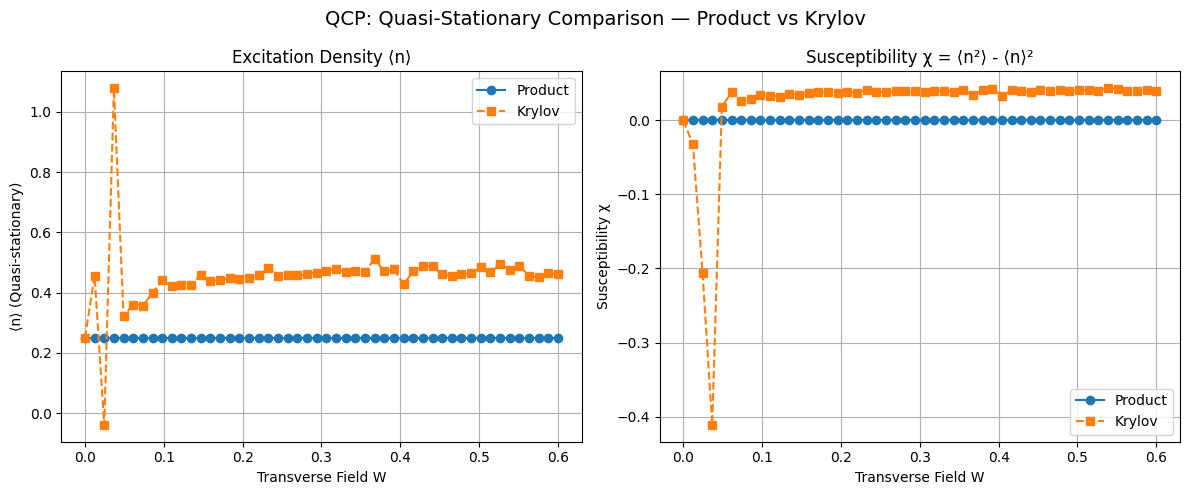

In [99]:
import numpy as np
from qutip import *
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Parameters
gamma = 0.1
W_list = np.linspace(0.0, 0.6, 50)
krylov_dim = 20
N = 4

# Qubit operators
sm = destroy(2)
sp = sm.dag()
sx = sm + sp
sy = 1j * (sm - sp)
sz = sp * sm - (qeye(2) - sp * sm)
Pr = sp * sm
id2 = qeye(2)

# Tensor op at site i
def op_on_site(op, i, N):
    return tensor([op if j == i else id2 for j in range(N)])

# QCP Hamiltonian
def build_H(W):
    H = 0
    for i in range(N):
        H += W * op_on_site(sx, i, N) * op_on_site(Pr, (i+1) % N, N)
    return H

# Lindblad operators and dynamics
L_ops = [op_on_site(sm, i, N) for i in range(N)]
def lindbladian(H, rho):
    drho = -1j * (H * rho - rho * H)
    for c in L_ops:
        drho += gamma * (c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c))
    return drho

# Quasi-stationary projection
vacuum_state = tensor([basis(2, 0) for _ in range(N)]).proj()
P_abs = vacuum_state
def project_out_absorbing(rho):
    Q = qeye(rho.dims[0]) - P_abs
    rho_qs = Q * rho * Q
    return rho_qs / rho_qs.tr()

# Observables
def excitation_density(rho):
    return np.mean([(rho * op_on_site(Pr, i, N)).tr().real for i in range(N)])

def excitation_density_squared(rho):
    total_n = sum(op_on_site(Pr, i, N) for i in range(N))
    return ((rho * total_n**2).tr().real) / (N**2)

# Product Ansatz
def rho_product(alpha):
    rho_sites = [(id2 + alpha[3*i]*sx + alpha[3*i+1]*sy + alpha[3*i+2]*sz)/2 for i in range(N)]
    return tensor(rho_sites)

def product_cost(alpha, H):
    rho = rho_product(alpha)
    drho = lindbladian(H, rho)
    return sum(abs(drho.eigenenergies()))

# Krylov
def frob_norm(rho):
    return np.sqrt((rho.dag() * rho).tr().real)

def build_krylov_basis(H, rho0, dim):
    basis = []
    vec = rho0 / frob_norm(rho0)
    basis.append(vec)
    for _ in range(1, dim):
        vec_new = lindbladian(H, basis[-1])
        for b in basis:
            vec_new -= (b.dag() * vec_new).tr().real * b
        norm = frob_norm(vec_new)
        if norm < 1e-10:
            break
        basis.append(vec_new / norm)
    return basis

def krylov_cost(alpha, basis, H):
    rho = sum(a * b for a, b in zip(alpha, basis))
    drho = lindbladian(H, rho)
    return sum(abs(drho.eigenenergies()))

# Storage
n_qs_prod, chi_qs_prod = [], []
n_qs_kry, chi_qs_kry = [], []

# Sweep loop
for W in W_list:
    H = build_H(W)

    # Product Ansatz
    alpha0 = np.random.randn(3 * N) * 0.1
    alpha0[2::3] = -1.
    res_prod = minimize(lambda a: product_cost(a, H), alpha0,
                        method='SLSQP', options={'ftol': 1e-9, 'disp': False, 'maxiter': 500})
    rho_prod = rho_product(res_prod.x)
    rho_qs_prod = project_out_absorbing(rho_prod)
    n_qs_p = excitation_density(rho_qs_prod)
    n2_qs_p = excitation_density_squared(rho_qs_prod)
    chi_qs_p = n2_qs_p - n_qs_p**2
    n_qs_prod.append(n_qs_p)
    chi_qs_prod.append(chi_qs_p)

    # Krylov Ansatz
    rho_seed = tensor([basis(2, 1) if i == 1 else basis(2, 0) for i in range(N)]).proj()
    krylov_basis = build_krylov_basis(H, rho_seed, krylov_dim)
    alpha_k0 = np.random.randn(len(krylov_basis)) * 0.1
    res_kry = minimize(lambda a: krylov_cost(a, krylov_basis, H), alpha_k0,
                       method='SLSQP', options={'ftol': 1e-9, 'disp': False, 'maxiter': 500})
    rho_kry = sum(a * b for a, b in zip(res_kry.x, krylov_basis))
    rho_qs_kry = project_out_absorbing(rho_kry)
    n_qs_k = excitation_density(rho_qs_kry)
    n2_qs_k = excitation_density_squared(rho_qs_kry)
    chi_qs_k = n2_qs_k - n_qs_k**2
    n_qs_kry.append(n_qs_k)
    chi_qs_kry.append(chi_qs_k)

import matplotlib.pyplot as plt

# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ⟨n⟩
ax[0].plot(W_list, n_qs_prod, 'o-', label="Product")
ax[0].plot(W_list, n_qs_kry, 's--', label="Krylov")
ax[0].set_xlabel("Transverse Field W")
ax[0].set_ylabel("⟨n⟩ (Quasi-stationary)")
ax[0].set_title("Excitation Density ⟨n⟩")
ax[0].legend()
ax[0].grid(True)

# χ
ax[1].plot(W_list, chi_qs_prod, 'o-', label="Product")
ax[1].plot(W_list, chi_qs_kry, 's--', label="Krylov")
ax[1].set_xlabel("Transverse Field W")
ax[1].set_ylabel("Susceptibility χ")
ax[1].set_title("Susceptibility χ = ⟨n²⟩ - ⟨n⟩²")
ax[1].legend()
ax[1].grid(True)

plt.suptitle("QCP: Quasi-Stationary Comparison — Product vs Krylov", fontsize=14)
plt.tight_layout()
plt.show()



/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/1435522510.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rho = sum(a * b for a, b in zip(res_kry.x, krylov_basis))


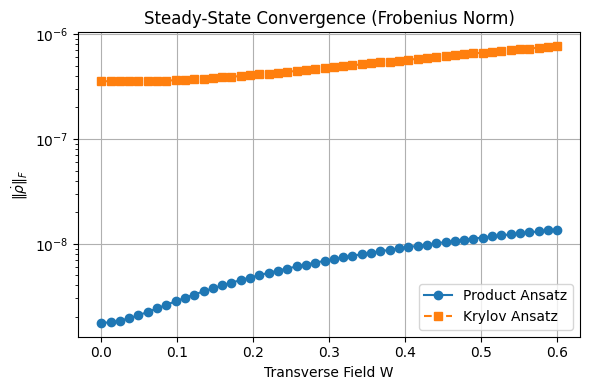

In [90]:
# Convergence norms
norm_dot_rho_prod = []
norm_dot_rho_kry = []

for i in range(len(W_list)):
    W = W_list[i]
    H = build_H(W)

    # Product
    rho = rho_product(res_prod.x)
    dot_rho = lindbladian(H, rho)
    norm_dot_rho_prod.append(frob_norm(dot_rho))

    # Krylov
    rho = sum(a * b for a, b in zip(res_kry.x, krylov_basis))
    dot_rho = lindbladian(H, rho)
    norm_dot_rho_kry.append(frob_norm(dot_rho))
plt.figure(figsize=(6, 4))
plt.plot(W_list, norm_dot_rho_prod, 'o-', label='Product Ansatz')
plt.plot(W_list, norm_dot_rho_kry, 's--', label='Krylov Ansatz')
plt.xlabel("Transverse Field W")
plt.ylabel(r"$\|\dot{\rho}\|_F$")
plt.yscale('log')
plt.title("Steady-State Convergence (Frobenius Norm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/920516508.py:56: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_n = sum(op_on_site(Pr, i, N) for i in range(N))


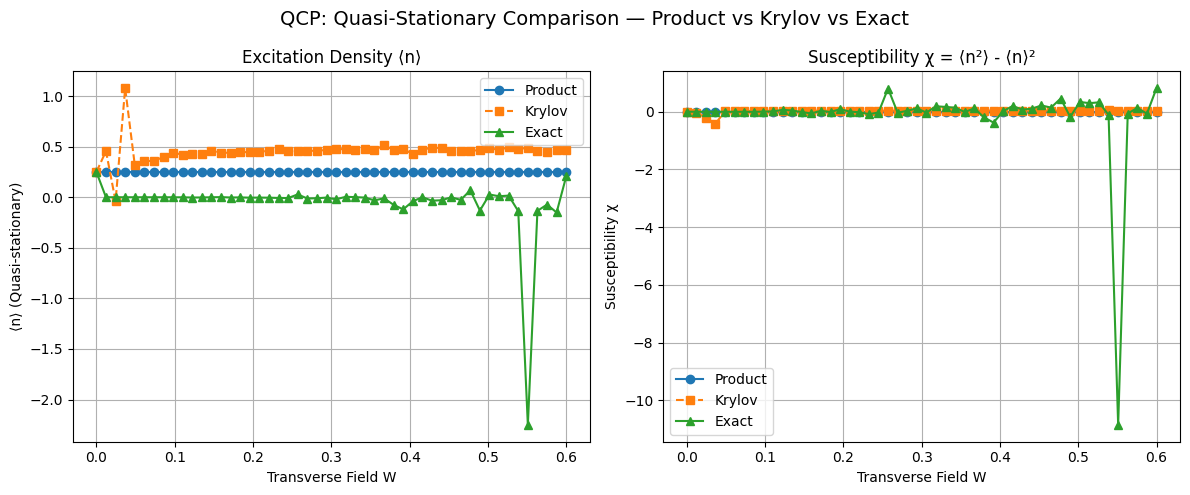

In [103]:
# Storage for exact sim
n_qs_exact, chi_qs_exact = [], []

# Time settings
tlist = np.linspace(0, 100, 500)

for W in W_list:
    H = build_H(W)
    # Initial state: single excitation at site 1
    rho0 = tensor([basis(2, 1) if i == 1 else basis(2, 0) for i in range(N)]).proj()
    
    # Time evolution via master equation
    result = mesolve(H, rho0, tlist, c_ops=L_ops, e_ops=[], progress_bar=None)
    
    # Final density matrix (quasi-steady if t → ∞)
    rho_final = result.states[-1]
    
    # Project out absorbing state and normalize
    rho_qs_exact = project_out_absorbing(rho_final)

    # Observables
    n_qs_e = excitation_density(rho_qs_exact)
    n2_qs_e = excitation_density_squared(rho_qs_exact)
    chi_qs_e = n2_qs_e - n_qs_e**2

    n_qs_exact.append(n_qs_e)
    chi_qs_exact.append(chi_qs_e)
# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ⟨n⟩
ax[0].plot(W_list, n_qs_prod, 'o-', label="Product")
ax[0].plot(W_list, n_qs_kry, 's--', label="Krylov")
ax[0].plot(W_list, n_qs_exact, '^-', label="Exact")
ax[0].set_xlabel("Transverse Field W")
ax[0].set_ylabel("⟨n⟩ (Quasi-stationary)")
ax[0].set_title("Excitation Density ⟨n⟩")
ax[0].legend()
ax[0].grid(True)

# χ
ax[1].plot(W_list, chi_qs_prod, 'o-', label="Product")
ax[1].plot(W_list, chi_qs_kry, 's--', label="Krylov")
ax[1].plot(W_list, chi_qs_exact, '^-', label="Exact")
ax[1].set_xlabel("Transverse Field W")
ax[1].set_ylabel("Susceptibility χ")
ax[1].set_title("Susceptibility χ = ⟨n²⟩ - ⟨n⟩²")
ax[1].legend()
ax[1].grid(True)

plt.suptitle("QCP: Quasi-Stationary Comparison — Product vs Krylov vs Exact", fontsize=14)
plt.tight_layout()
plt.show()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.9550354153468667e-06
            Iterations: 32
            Function evaluations: 282
            Gradient evaluations: 32


/var/folders/v4/99ts0l0n3nn11xzhtf5d51dw0000gn/T/ipykernel_8561/3965019467.py:58: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rho = sum(a * b for a, b in zip(alpha, krylov_basis))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0006866801357151748
            Iterations: 49
            Function evaluations: 597
            Gradient evaluations: 49


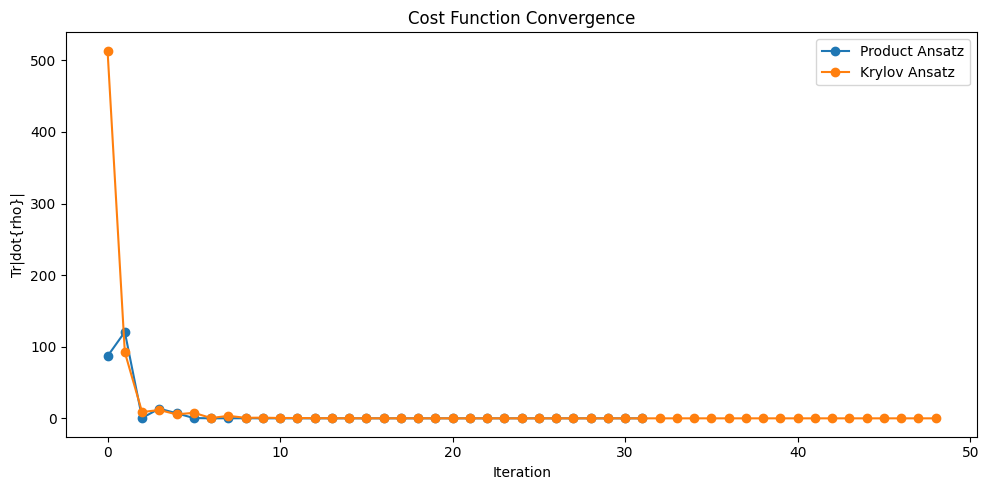


--- Final Comparison ---
Product Ansatz Final Cost: 0.000003
Krylov Ansatz  Final Cost: 0.000687


In [19]:

from qutip import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Parameters
W = 4.0
gamma = 1.0
krylov_dim = 10

# Operators
sm = destroy(2)
sp = sm.dag()
Pr = sp * sm
sx = sm + sp
sy = 1j * (sm - sp)
sz = Pr - (qeye(2) - Pr)
s0 = qeye(2)

# QCP Hamiltonian
H = W * (tensor(sx, Pr) + tensor(Pr, sx))
L_ops = [tensor(sm, s0), tensor(s0, sm)]

# Lindblad time derivative
def lindbladian(rho):
    drho = -1j * (H * rho - rho * H)
    for c in L_ops:
        drho += gamma * (c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c))
    return drho

### --- Product State Ansatz --- ###
def product_rho(alpha):
    r1 = (s0 + alpha[0]*sx + alpha[1]*sy + alpha[2]*sz) / 2
    r2 = (s0 + alpha[3]*sx + alpha[4]*sy + alpha[5]*sz) / 2
    return tensor(r1, r2)

def product_cost(alpha):
    rho = product_rho(alpha)
    drho = lindbladian(rho)
    return sum(abs(drho.eigenenergies()))

product_history = []
def product_callback(alpha):
    product_history.append(product_cost(alpha))

### --- Krylov Ansatz --- ###
rho0 = tensor(basis(2, 1).proj(), basis(2, 0).proj())  # Single seed
def build_krylov_basis(rho_init, dim):
    basis = [rho_init]
    for _ in range(1, dim):
        next_rho = lindbladian(basis[-1]).unit()
        basis.append(next_rho)
    return basis

krylov_basis = build_krylov_basis(rho0, krylov_dim)

def krylov_cost(alpha):
    rho = sum(a * b for a, b in zip(alpha, krylov_basis))
    drho = lindbladian(rho)
    return sum(abs(drho.eigenenergies()))

krylov_history = []
def krylov_callback(alpha):
    krylov_history.append(krylov_cost(alpha))

### --- Run Both Optimizations --- ###
alpha_prod0 = np.random.rand(6) * 0.1
alpha_prod0[2] = -1.
alpha_prod0[5] = -1.

res_prod = minimize(product_cost, alpha_prod0, method='SLSQP', callback=product_callback, options={'ftol':1e-6, 'disp':True})
final_cost_prod = product_cost(res_prod.x)

alpha_kry0 = np.random.rand(krylov_dim)
res_kry = minimize(krylov_cost, alpha_kry0, method='SLSQP', callback=krylov_callback, options={'ftol':1e-6, 'disp':True})
final_cost_kry = krylov_cost(res_kry.x)

### --- Plot Comparison --- ###
plt.figure(figsize=(10, 5))
plt.plot(product_history, '-o', label='Product Ansatz')
plt.plot(krylov_history, '-o', label='Krylov Ansatz')
plt.title("Cost Function Convergence")
plt.xlabel("Iteration")
plt.ylabel("Tr|dot{rho}|")
plt.legend()
plt.tight_layout()
plt.show()

### --- Print Results --- ###
print("\n--- Final Comparison ---")
print(f"Product Ansatz Final Cost: {final_cost_prod:.6f}")
print(f"Krylov Ansatz  Final Cost: {final_cost_kry:.6f}")


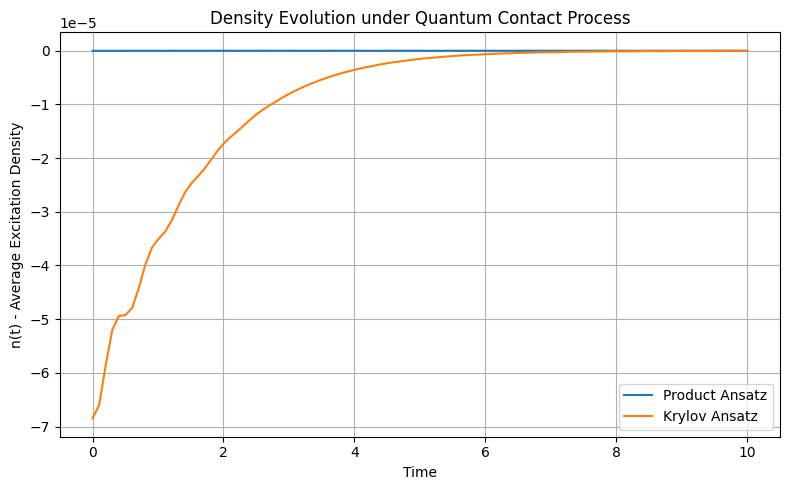

In [21]:
### --- Time Evolution for n(t) --- ###
times = np.linspace(0, 10, 100)
n_op1 = tensor(Pr, qeye(2))
n_op2 = tensor(qeye(2), Pr)

# Initial states
rho_prod = product_rho(res_prod.x)
rho_kry = sum([a * b for a, b in zip(res_kry.x, krylov_basis)])

# Solve Lindblad dynamics
evo_prod = mesolve(H, rho_prod, times, c_ops=L_ops, e_ops=[n_op1, n_op2])
evo_kry = mesolve(H, rho_kry, times, c_ops=L_ops, e_ops=[n_op1, n_op2])

# Compute average density n(t)
n_prod = (np.array(evo_prod.expect[0]) + np.array(evo_prod.expect[1])) / 2.0
n_kry = (np.array(evo_kry.expect[0]) + np.array(evo_kry.expect[1])) / 2.0

### --- Plot n(t) --- ###
plt.figure(figsize=(8, 5))
plt.plot(times, n_prod, label='Product Ansatz')
plt.plot(times, n_kry, label='Krylov Ansatz')
plt.xlabel("Time")
plt.ylabel("n(t) - Average Excitation Density")
plt.title("Density Evolution under Quantum Contact Process")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
n_prod

array([-1.10466155e-08, -1.13849807e-08, -1.20850610e-08, -1.13639513e-08,
       -1.17440771e-08, -9.16186321e-09, -7.17410588e-09, -6.28127137e-09,
       -8.29499235e-09, -9.53846831e-09, -2.89277824e-09, -2.63385204e-09,
        7.28570470e-10, -3.81005430e-09, -4.05374710e-09, -1.09126964e-08,
       -6.25677443e-09, -4.67782928e-09,  4.11362980e-09,  2.52626042e-09,
        2.08362031e-09, -1.52128418e-09, -2.79478878e-09, -4.63519938e-09,
       -6.92845915e-09, -2.71658409e-09, -9.60700811e-10,  6.33880908e-09,
        2.02727859e-09,  3.15821509e-09, -2.04094098e-09, -7.59360741e-10,
       -6.80200041e-09, -3.35632760e-09, -4.88996851e-09, -2.08173105e-09,
       -1.50899172e-09,  2.68402064e-09,  3.46784486e-09,  2.84048281e-09,
        1.84064537e-09, -5.75420883e-09, -4.35635529e-09, -6.45399921e-09,
       -6.68763176e-10, -5.11029525e-10,  6.40762819e-09,  2.24013644e-09,
        4.14637269e-09,  6.38168120e-10,  9.57933255e-10, -3.99042366e-09,
       -3.15573393e-09, -

In [25]:
n_kry

array([-6.84733115e-05, -6.59920963e-05, -5.85775088e-05, -5.19428143e-05,
       -4.93961748e-05, -4.92142664e-05, -4.78907254e-05, -4.41987793e-05,
       -3.97786139e-05, -3.66445664e-05, -3.50266793e-05, -3.36728952e-05,
       -3.15536142e-05, -2.88412932e-05, -2.63796440e-05, -2.46317719e-05,
       -2.32936987e-05, -2.18548967e-05, -2.01745547e-05, -1.84808735e-05,
       -1.70667199e-05, -1.59308708e-05, -1.48726250e-05, -1.37751113e-05,
       -1.26518922e-05, -1.16431943e-05, -1.07864772e-05, -1.00195321e-05,
       -9.26293752e-06, -8.51605713e-06, -7.83972888e-06, -7.23683990e-06,
       -6.67514262e-06, -6.15360905e-06, -5.66371737e-06, -5.22243845e-06,
       -4.80005243e-06, -4.42098274e-06, -4.05831091e-06, -3.73812998e-06,
       -3.42860364e-06, -3.15677812e-06, -2.91058304e-06, -2.67220516e-06,
       -2.44002163e-06, -2.23195079e-06, -2.06874501e-06, -1.90940379e-06,
       -1.74358847e-06, -1.58509977e-06, -1.45243268e-06, -1.33826294e-06,
       -1.23728656e-06, -